## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import cv2

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models_3 import Net

# Instantiate the Net model
net = Net()
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop2): Dropout(p=0.15, inplace=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop4): Dropout(p=0.25, inplace=False)
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=

In [3]:
# Weight initialization from normal distribution
def weights_init_normal(model):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02.
    :param model: A module or layer in a neural netowork model 
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = model.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Conv2d or ConvTranspose2d in a model
    # - model.weight.data is sampled from a normal distribution with mean = 0 and std_dev = 0.02
    # remark: bias is switched off here in the convolutional layers
    if classname.find('Conv') != -1:
        print('Updating weights for | ' + str(classname))
        #torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
        model.weight.data.normal_(0.0, 0.02)        
        model.bias.data.fill_(0.0)
    
    # for every Linear layer in a model
    # - model.weight.data is sampled from a normal distribution with mean = 0 and std_dev = 0.02
    # - model.bias.data is set to zero
    if classname.find('Linear') != -1:
        print('Updating weights for | ' + str(classname))
        #torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
        model.weight.data.normal_(0.0, 0.02)
        model.bias.data.fill_(0.0)

# Weight initialization using Xavier / Glorot method sampling from a uniform distribution
def weights_init_xavier_uniform(model):
    """
    Applies initial weights to certain layers in a model.
    The weights are filled in using a uniform distribution according to the method described in 
    "Understanding the difficulty of training deep feedforward neural networks" by Glorot, X. 
    and Bengio, Y. (2010). The resulting tensor will have values sampled from a distribution 
    U(−a,a) where a = gain x sqrt(6 / (fan_in+fan_out). Also known as Glorot initialization.
    :param model: A module or layer in a neural netowork model  
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = model.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Conv2d or ConvTranspose2d in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # remark: bias is switched off here in the convolutional layers
    if classname.find('Conv') != -1:
        print('Updating weights for | ' + str(classname))
        nn.init.xavier_uniform_(model.weight.data, 
                               gain=nn.init.calculate_gain('relu')) # elu not supported => use relu
        model.bias.data.fill_(0.0)
    
    # for every Linear layer in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # - model.bias.data is set to zero
    if classname.find('Linear') != -1:
        print('Updating weights for | ' + str(classname))
        nn.init.xavier_uniform_(model.weight.data, 
                               gain=nn.init.calculate_gain('leaky_relu', 0.01))
        #nn.init.xavier_uniform_(model.weight.data, 
        #                       gain=nn.init.calculate_gain('relu'))
        model.bias.data.fill_(0.0)

# Weight initialization using Xavier / Glorot method sampling from a normal distribution
def weights_init_xavier_normal(model):
    """
    Applies initial weights to certain layers in a model.
    The weights are filled in using a normal distribution according to the method described in 
    "Understanding the difficulty of training deep feedforward neural networks" by Glorot, X. 
    and Bengio, Y. (2010). The resulting tensor will have values sampled from N(0,std²) where
    std = gain x sqrt(2 / (fan_in+fan_out). Also known as Glorot initialization.
    :param model: A module or layer in a neural netowork model      
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = model.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Conv2d or ConvTranspose2d in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # remark: bias is switched off here in the convolutional layers
    if classname.find('Conv') != -1:
        print('Updating weights for | ' + str(classname))
        nn.init.xavier_normal_(model.weight.data, 
                               gain=nn.init.calculate_gain('relu')) # elu not supported => use relu
        model.bias.data.fill_(0.0)
    
    # for every Linear layer in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # - model.bias.data is set to zero
    if classname.find('Linear') != -1:
        print('Updating weights for | ' + str(classname))
        nn.init.xavier_normal_(model.weight.data, 
                               gain=nn.init.calculate_gain('leaky_relu', 0.01))
        #nn.init.xavier_normal_(model.weight.data, 
        #                       gain=nn.init.calculate_gain('relu'))
        model.bias.data.fill_(0.0)

In [4]:
# Initialize model weights using one of the below methods (else use pytorch's default method)
# net.apply(weights_init_normal) # normal distribution
# net.apply(weights_init_xavier_uniform) # Xavier/Glorot method with uniform distribution
# net.apply(weights_init_xavier_normal) # Xavier/Glorot method with normal distribution

In [5]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('GPU is available => Train on GPU using CUDA.')
    # Move Net model to cuda if GPU is available
    net.cuda()
    print('Net model moved to device.')
else:
    print(' GPU is not available => Train on CPU')

GPU is available => Train on GPU using CUDA.
Net model moved to device.


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(), # Do NOT apply Normalize() before Rescale() or RandomCrop()!
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [7]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

# iterate through the transformed dataset and print some stats about the first few samples
print('Number of images in the transformed dataset: ', len(transformed_dataset))
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images in the transformed dataset:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [8]:
# Split transformed dataset into training and validation set at a ratio 9 : 1
train_length = int(0.9245 * len(transformed_dataset)) # train: 3200 | valid: 262
# train_length = int(0.913 * len(transformed_dataset)) # train: 3160 | valid: 302
valid_length = len(transformed_dataset) - train_length
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, (train_length, valid_length))

# Print length of training and validation dataset
print('Number of images in off-split training dataset:   {:>4}'.format(train_length))
print('Number of images in off-split validation dataset: {:>4}'.format(valid_length))

Number of images in off-split training dataset:   3200
Number of images in off-split validation dataset:  262


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [9]:
# load training and validation data in batches
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [10]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [11]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [12]:
# test the model on a batch of test images

def net_sample_output():
    
    # Switch off gradients for efficient prediction
    with torch.no_grad():
        
        # Set model to evaluation mode
        net.eval()
        
        # iterate through the test dataset
        for i, sample in enumerate(test_loader):
            
            # get sample data: images and ground truth keypoints
            images = sample['image']
            key_pts = sample['keypoints']
            
            # convert images to FloatTensors and move to cuda if available
            if use_cuda:
                images = images.type(torch.FloatTensor).cuda()
            else:
                images = images.type(torch.FloatTensor)
            
            # forward pass to get net output
            output_pts = net(images)
            
            # reshape to batch_size x 68 x 2 pts
            output_pts = output_pts.view(output_pts.size()[0], 68, -1)
            
            # Copy images and output_pts tensors back to CPU if they are not there yet
            images = images.cpu()
            output_pts = output_pts.detach().cpu() # remove "requires gradients" by detaching
            
            # break after first image batch is tested
            if i == 0:
                return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [13]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, test_gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(test_gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [14]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

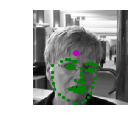

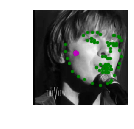

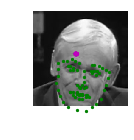

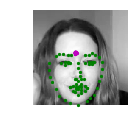

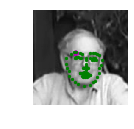

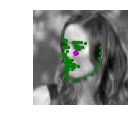

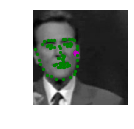

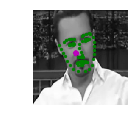

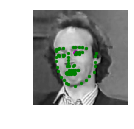

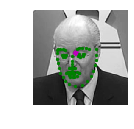

In [15]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, test_gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        
        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
                
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_key_pts = None
        if test_gt_pts is not None:
            # un-transform the ground truth key_pts data
            ground_truth_key_pts = test_gt_pts[i].data
            ground_truth_key_pts = ground_truth_key_pts.numpy()
            # undo normalization of keypoints
            ground_truth_key_pts = ground_truth_key_pts*50.0+100
                
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_key_pts)
        
        plt.axis('off')
        
    plt.show()
    
# visualize one batch of test images
visualize_output(test_images, test_outputs, test_gt_pts, batch_size=10)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [16]:
## TODO: Define the loss and optimization
import torch.optim as optim
from torch.optim import lr_scheduler

# nn.SmoothL1Loss() creates a criterion that uses a squared term if the absolute element-wise error 
# falls below 1 and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in 
# some cases prevents exploding gradients (e.g. see Fast R-CNN paper by Ross Girshick). Also known 
# as the Huber loss.
criterion = nn.SmoothL1Loss()

# nn.MSELoss() creates a criterion that measures the mean squared error (squared L2 norm) between 
# each element in the input xxx and target yyy.
# criterion = nn.MSELoss()


# Select optimizer
selected_optimizer = 'Adam'
# selected_optimizer = 'SGD' # leads to accumulated keypoint clouds => seems not useful for this task => use Adam

# Create optimizers for the discriminator and generator
if selected_optimizer == 'Adam':
    
    # Optimization parameters for Adam optimizer
    # lr = 5e-2            # learning rate (default: 1e-3)
    # lr = 1e-2            # learning rate (default: 1e-3)
    # lr = 5e-3            # learning rate (default: 1e-3)
    # lr = 2e-3              # learning rate (default: 1e-3)
    lr = 1e-3            # learning rate (default: 1e-3)
    # lr = 5e-4            # learning rate (default: 1e-3)
    # lr = 5e-2            # learning rate (default: 1e-3)
    # lr = 1e-4            # learning rate (default: 1e-3)
    beta1 = 0.5          # lower beta coefficient for computing running averages of gradient and its square (default: 0.9
    beta2 = 0.999        # upper beta coefficient for computing running averages of gradient and its square (default: 0.999)
    eps = 1e-08          # term added to the denominator to improve numerical stability (default: 1e-8)
    #weight_decay = 0.0   # weight decay resp. L2 penalty (default: 0)
    weight_decay = 1e-07 # weight decay resp. L2 penalty (default: 0)
    # weight_decay = 1e-08 # weight decay resp. L2 penalty (default: 0)

    # Create optimizer for the CNN model built from scratch
    optimizer = optim.Adam(net.parameters(), lr, [beta1, beta2], eps, weight_decay)
    
    # Create scheduler for learning rate decay by a factor of 0.5 every x epochs
    # lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
    lr_scheduler = None
    
elif selected_optimizer == 'SGD':
    
    # Optimization parameters for stochastic gradient descent (SGD) optimizer
    # lr = 5e-2            # learning rate
    # lr = 1e-2            # learning rate
    # lr = 5e-3            # learning rate
    # lr = 2e-3            # learning rate
    lr = 1e-3            # learning rate
    # lr = 1e-4            # learning rate
    momentum = 0.0       # momentum factor (default: 0.0)
    # momentum = 0.4       # momentum factor (default: 0.0)
    dampening = 0.0      # dampening for momentum (default: 0.0)
    # dampening = 0.1      # dampening for momentum (default: 0.0)
    weight_decay = 0.0   # weight decay resp. L2 penalty (default: 0.0)
    # weight_decay = 1e-7  # weight decay resp. L2 penalty (default: 0.0)
    # weight_decay = 1e-8  # weight decay resp. L2 penalty (default: 0.0)

    # Create optimizer for the CNN model built from scratch
    optimizer = optim.SGD(net.parameters(), lr, momentum, dampening, weight_decay)
    
    # Create scheduler for learning rate decay by a factor of 0.5 every x epochs
    # lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    lr_scheduler = None

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [17]:
## TODO: change the name to something uniqe for each new model
# The best keypoint model will be stored automatically during training upon decrease of validation loss 
# under the below declared directory and model name
model_dir = 'saved_models/'
# model name and path for minimum validation loss
model_name_min_loss = 'keypoints_model_min_loss.pt'
model_path_min_loss = model_dir + model_name_min_loss
# model name and path for last state after all training epochs
model_name_last_state = 'keypoints_model_last_state.pt'
model_path_last_state = model_dir + model_name_last_state

In [18]:
def train_net(n_epochs,
              train_loader,
              valid_loader,
              model,
              optimizer,
              criterion,
              scheduler,
              use_cuda,
              model_path_min_loss,
              model_path_last_state):
    
    # prepare the net model for training
    model.train()
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    # initialize variables to monitor the history of average training and validation loss
    train_loss_history = np.zeros(n_epochs)
    valid_loss_history = np.zeros(n_epochs)
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
                
        # Initialize average running training and validation loss
        running_train_loss = 0.0
        running_valid_loss = 0.0
        
        #######################
        # train the Net model #
        #######################
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten keypoint array
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to float tensors for regression loss and move to cuda if available
            if use_cuda:
                key_pts = key_pts.type(torch.FloatTensor).cuda()
                images = images.type(torch.FloatTensor).cuda()
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
                
            # forward pass to get predicted outputs
            output_pts = model(images)

            # calculate the training loss between predicted and target keypoints
            train_batch_loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients for each new batch
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            train_batch_loss.backward()

            # update the weights
            optimizer.step()
            
            # Adapt optimization parameters (call after optimization step has been performed)
            if scheduler is not None:
                scheduler.step()
            
            # convert current train_batch_loss into a scalar and add it to the avg. running_train_loss, use .item()
            running_train_loss = (running_train_loss * batch_i + train_batch_loss.item()) / (batch_i + 1)
            
            # store the average training loss of the current epoch
            train_loss_history[epoch] = running_train_loss
            
            # print training loss statistics
            if batch_i % 10 == 9:    # print training loss every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Training Loss: {}'.format(epoch + 1, 
                                                                            batch_i+1, 
                                                                            running_train_loss))
            
        ##########################    
        # validate the Net model #
        ##########################
        
        # set net model to evaluation mode
        model.eval()
        
        # validate on batches of data, assumes you already have valid loader
        for batch_i, data in enumerate(valid_loader):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten keypoint array
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to float tensors for regression loss and move to cuda if available
            if use_cuda:
                key_pts = key_pts.type(torch.FloatTensor).cuda()
                images = images.type(torch.FloatTensor).cuda()
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
            
            # forward pass to get predicted outputs
            output_pts = model(images)

            # calculate the validation batch loss between predicted and target keypoints
            valid_batch_loss = criterion(output_pts, key_pts)
            
            # convert current valid_batch_loss into a scalar and add it to the avg. running_valid_loss, use .item()
            running_valid_loss = (running_valid_loss * batch_i + valid_batch_loss.item()) / (batch_i + 1)
            
            # store the average validation loss of the current epoch
            valid_loss_history[epoch] = running_valid_loss
            
            # print validation loss statistics
            if batch_i % 10 == 9:    # print validation loss every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Validation Loss: {}'.format(epoch + 1, 
                                                                              batch_i+1, 
                                                                              running_valid_loss))
            
        # print training and validation loss statistics per epoch
        print('\nEpoch: {}, Avg. Training Loss: {} Avg. Validation Loss: {}\n'.format(epoch + 1, 
                                                                                    running_train_loss, 
                                                                                    running_valid_loss))
        
        ## TODO: save the net if validation loss has decreased
        if running_valid_loss <= valid_loss_min:
            print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving net ...\n'.format(
                valid_loss_min,
                running_valid_loss))
            # save the net model parameters with minimum validation loss as state dictionary under the given path
            torch.save(model.state_dict(), model_path_min_loss)
            # Update minimum validation loss achieved so far
            valid_loss_min = running_valid_loss
        
        # set net model back to training mode
        model.eval()
    
    # Print final message upon finishing training process
    print('Finished Training')
    
    # save the net model parameter of last state of the training process as state directory under the given path
    print('\tValidation loss of last state: {:.6f}.  Saving net ...\n'.format(running_valid_loss))
    torch.save(model.state_dict(), model_path_last_state)
    
    # Return the last state of trained net model plus training and validation loss history
    return model, train_loss_history, valid_loss_history

In [19]:
import time

# number of training epochs
n_epochs = 500 # start small, and increase when you've decided on your model structure and hyperparams

# start timer
start_time = time.time()

# train the cnn model
net, train_loss_history, valid_loss_history = train_net(n_epochs,
                                                        train_loader,
                                                        valid_loader,
                                                        net,
                                                        optimizer,
                                                        criterion,
                                                        lr_scheduler,
                                                        use_cuda,
                                                        model_path_min_loss,
                                                        model_path_last_state)

# get stop time
stop_time = time.time()

# evaluate elapsed time
elapsed_time = stop_time - start_time
print('\tElapsed time: {:.0f} h {:.0f} min {:.0f} s'.format(elapsed_time//3600, 
                                                            (elapsed_time%3600)//60,
                                                            (elapsed_time%3600)%60))

Epoch: 1, Batch: 10, Avg. Training Loss: 0.22853914052248
Epoch: 1, Batch: 20, Avg. Training Loss: 0.19436559677124024
Epoch: 1, Batch: 30, Avg. Training Loss: 0.1805981899301211
Epoch: 1, Batch: 40, Avg. Training Loss: 0.16900297328829766
Epoch: 1, Batch: 50, Avg. Training Loss: 0.1630479091405869
Epoch: 1, Batch: 60, Avg. Training Loss: 0.15750632497171563
Epoch: 1, Batch: 70, Avg. Training Loss: 0.15212565692407748
Epoch: 1, Batch: 80, Avg. Training Loss: 0.14878181684762243
Epoch: 1, Batch: 90, Avg. Training Loss: 0.14715271103713248
Epoch: 1, Batch: 100, Avg. Training Loss: 0.1456864993274212
Epoch: 1, Batch: 110, Avg. Training Loss: 0.14270067824558783
Epoch: 1, Batch: 120, Avg. Training Loss: 0.14104015243550147
Epoch: 1, Batch: 130, Avg. Training Loss: 0.13844623428124653
Epoch: 1, Batch: 140, Avg. Training Loss: 0.13614034620778906
Epoch: 1, Batch: 150, Avg. Training Loss: 0.13416346758604056
Epoch: 1, Batch: 160, Avg. Training Loss: 0.13212964814156297
Epoch: 1, Batch: 170, A

Epoch: 6, Batch: 180, Avg. Training Loss: 0.023748079801185273
Epoch: 6, Batch: 190, Avg. Training Loss: 0.024297399500286903
Epoch: 6, Batch: 200, Avg. Training Loss: 0.023918261528015145
Epoch: 6, Batch: 10, Avg. Validation Loss: 0.01770347049459815

Epoch: 6, Avg. Training Loss: 0.023918261528015145 Avg. Validation Loss: 0.026130942134734464

Epoch: 7, Batch: 10, Avg. Training Loss: 0.0318388419225812
Epoch: 7, Batch: 20, Avg. Training Loss: 0.024998866533860565
Epoch: 7, Batch: 30, Avg. Training Loss: 0.024803923225651184
Epoch: 7, Batch: 40, Avg. Training Loss: 0.02393379888962954
Epoch: 7, Batch: 50, Avg. Training Loss: 0.024137842692434786
Epoch: 7, Batch: 60, Avg. Training Loss: 0.022173130714024106
Epoch: 7, Batch: 70, Avg. Training Loss: 0.020975896450025695
Epoch: 7, Batch: 80, Avg. Training Loss: 0.0209422116051428
Epoch: 7, Batch: 90, Avg. Training Loss: 0.02197639288173781
Epoch: 7, Batch: 100, Avg. Training Loss: 0.02156845790334045
Epoch: 7, Batch: 110, Avg. Training Lo

Epoch: 12, Batch: 110, Avg. Training Loss: 0.013196575722064485
Epoch: 12, Batch: 120, Avg. Training Loss: 0.012709432099169742
Epoch: 12, Batch: 130, Avg. Training Loss: 0.01332016931488537
Epoch: 12, Batch: 140, Avg. Training Loss: 0.012872442054296178
Epoch: 12, Batch: 150, Avg. Training Loss: 0.012709183460101487
Epoch: 12, Batch: 160, Avg. Training Loss: 0.012576146822539162
Epoch: 12, Batch: 170, Avg. Training Loss: 0.012965358648558753
Epoch: 12, Batch: 180, Avg. Training Loss: 0.012675141957071095
Epoch: 12, Batch: 190, Avg. Training Loss: 0.012526429655324474
Epoch: 12, Batch: 200, Avg. Training Loss: 0.012468532926868649
Epoch: 12, Batch: 10, Avg. Validation Loss: 0.013458409253507853

Epoch: 12, Avg. Training Loss: 0.012468532926868649 Avg. Validation Loss: 0.012299887507277377

Epoch: 13, Batch: 10, Avg. Training Loss: 0.013653092924505473
Epoch: 13, Batch: 20, Avg. Training Loss: 0.013374858116731048
Epoch: 13, Batch: 30, Avg. Training Loss: 0.014206152549013496
Epoch: 13,

Epoch: 18, Batch: 40, Avg. Training Loss: 0.007478552439715713
Epoch: 18, Batch: 50, Avg. Training Loss: 0.007309134341776371
Epoch: 18, Batch: 60, Avg. Training Loss: 0.007091007742565126
Epoch: 18, Batch: 70, Avg. Training Loss: 0.006800655654764601
Epoch: 18, Batch: 80, Avg. Training Loss: 0.006575863948091865
Epoch: 18, Batch: 90, Avg. Training Loss: 0.006792431275567247
Epoch: 18, Batch: 100, Avg. Training Loss: 0.006709628493990749
Epoch: 18, Batch: 110, Avg. Training Loss: 0.007011657796630805
Epoch: 18, Batch: 120, Avg. Training Loss: 0.006845157721545547
Epoch: 18, Batch: 130, Avg. Training Loss: 0.006712969027173061
Epoch: 18, Batch: 140, Avg. Training Loss: 0.006777329702994653
Epoch: 18, Batch: 150, Avg. Training Loss: 0.0067667006747797135
Epoch: 18, Batch: 160, Avg. Training Loss: 0.006805783024174161
Epoch: 18, Batch: 170, Avg. Training Loss: 0.0068051089340930475
Epoch: 18, Batch: 180, Avg. Training Loss: 0.006712260879834907
Epoch: 18, Batch: 190, Avg. Training Loss: 0


Epoch: 23, Avg. Training Loss: 0.08943489110097287 Avg. Validation Loss: 0.0904835832907873

Epoch: 24, Batch: 10, Avg. Training Loss: 0.10036637783050537
Epoch: 24, Batch: 20, Avg. Training Loss: 0.08623090516775847
Epoch: 24, Batch: 30, Avg. Training Loss: 0.08294016694029173
Epoch: 24, Batch: 40, Avg. Training Loss: 0.07945843636989594
Epoch: 24, Batch: 50, Avg. Training Loss: 0.07986961491405964
Epoch: 24, Batch: 60, Avg. Training Loss: 0.0805349271123608
Epoch: 24, Batch: 70, Avg. Training Loss: 0.07805373301463468
Epoch: 24, Batch: 80, Avg. Training Loss: 0.08029527529142796
Epoch: 24, Batch: 90, Avg. Training Loss: 0.08015191650225055
Epoch: 24, Batch: 100, Avg. Training Loss: 0.07920255668461319
Epoch: 24, Batch: 110, Avg. Training Loss: 0.07916703827001828
Epoch: 24, Batch: 120, Avg. Training Loss: 0.07891270328933991
Epoch: 24, Batch: 130, Avg. Training Loss: 0.07869402935298586
Epoch: 24, Batch: 140, Avg. Training Loss: 0.0788491026365331
Epoch: 24, Batch: 150, Avg. Trainin

Epoch: 29, Batch: 180, Avg. Training Loss: 0.03759810211033455
Epoch: 29, Batch: 190, Avg. Training Loss: 0.037479797353673905
Epoch: 29, Batch: 200, Avg. Training Loss: 0.03729879246558992
Epoch: 29, Batch: 10, Avg. Validation Loss: 0.031668235920369624

Epoch: 29, Avg. Training Loss: 0.03729879246558992 Avg. Validation Loss: 0.03648429703624808

Epoch: 30, Batch: 10, Avg. Training Loss: 0.02715981975197792
Epoch: 30, Batch: 20, Avg. Training Loss: 0.030729669239372016
Epoch: 30, Batch: 30, Avg. Training Loss: 0.03186046797782181
Epoch: 30, Batch: 40, Avg. Training Loss: 0.03089344361796974
Epoch: 30, Batch: 50, Avg. Training Loss: 0.03106788579374551
Epoch: 30, Batch: 60, Avg. Training Loss: 0.029569578201820445
Epoch: 30, Batch: 70, Avg. Training Loss: 0.02917907046420233
Epoch: 30, Batch: 80, Avg. Training Loss: 0.02901655253954231
Epoch: 30, Batch: 90, Avg. Training Loss: 0.02907923304786284
Epoch: 30, Batch: 100, Avg. Training Loss: 0.028698570542037484
Epoch: 30, Batch: 110, Avg

Epoch: 35, Batch: 130, Avg. Training Loss: 0.022609667788044765
Epoch: 35, Batch: 140, Avg. Training Loss: 0.022583591053262353
Epoch: 35, Batch: 150, Avg. Training Loss: 0.022549434533963596
Epoch: 35, Batch: 160, Avg. Training Loss: 0.022372480516787613
Epoch: 35, Batch: 170, Avg. Training Loss: 0.022047211980337596
Epoch: 35, Batch: 180, Avg. Training Loss: 0.022484208369213665
Epoch: 35, Batch: 190, Avg. Training Loss: 0.022417086402052318
Epoch: 35, Batch: 200, Avg. Training Loss: 0.022030839542858293
Epoch: 35, Batch: 10, Avg. Validation Loss: 0.03726721899583936

Epoch: 35, Avg. Training Loss: 0.022030839542858293 Avg. Validation Loss: 0.02958916423513609

Epoch: 36, Batch: 10, Avg. Training Loss: 0.020128071121871472
Epoch: 36, Batch: 20, Avg. Training Loss: 0.017305003525689245
Epoch: 36, Batch: 30, Avg. Training Loss: 0.02133258258303006
Epoch: 36, Batch: 40, Avg. Training Loss: 0.022639317577704786
Epoch: 36, Batch: 50, Avg. Training Loss: 0.02302757788449526
Epoch: 36, Batc

Epoch: 41, Batch: 80, Avg. Training Loss: 0.014073128084419295
Epoch: 41, Batch: 90, Avg. Training Loss: 0.01411324128922489
Epoch: 41, Batch: 100, Avg. Training Loss: 0.014242702964693307
Epoch: 41, Batch: 110, Avg. Training Loss: 0.014558937679976226
Epoch: 41, Batch: 120, Avg. Training Loss: 0.014621725624116759
Epoch: 41, Batch: 130, Avg. Training Loss: 0.014928747821026123
Epoch: 41, Batch: 140, Avg. Training Loss: 0.015403840670894299
Epoch: 41, Batch: 150, Avg. Training Loss: 0.01541234357903401
Epoch: 41, Batch: 160, Avg. Training Loss: 0.015505844575818628
Epoch: 41, Batch: 170, Avg. Training Loss: 0.015638000463299898
Epoch: 41, Batch: 180, Avg. Training Loss: 0.015790086353404658
Epoch: 41, Batch: 190, Avg. Training Loss: 0.016011489324859886
Epoch: 41, Batch: 200, Avg. Training Loss: 0.015828904132358733
Epoch: 41, Batch: 10, Avg. Validation Loss: 0.014663481339812278

Epoch: 41, Avg. Training Loss: 0.015828904132358733 Avg. Validation Loss: 0.015108304153032163

Epoch: 42,

Epoch: 47, Batch: 20, Avg. Training Loss: 0.00886789639480412
Epoch: 47, Batch: 30, Avg. Training Loss: 0.00842221143345038
Epoch: 47, Batch: 40, Avg. Training Loss: 0.008297362131997943
Epoch: 47, Batch: 50, Avg. Training Loss: 0.0082365810405463
Epoch: 47, Batch: 60, Avg. Training Loss: 0.008275706297717993
Epoch: 47, Batch: 70, Avg. Training Loss: 0.010246343225506802
Epoch: 47, Batch: 80, Avg. Training Loss: 0.011671188642503699
Epoch: 47, Batch: 90, Avg. Training Loss: 0.011624468288694824
Epoch: 47, Batch: 100, Avg. Training Loss: 0.011340818665921692
Epoch: 47, Batch: 110, Avg. Training Loss: 0.011115480337122629
Epoch: 47, Batch: 120, Avg. Training Loss: 0.01092037759178008
Epoch: 47, Batch: 130, Avg. Training Loss: 0.010819306385775029
Epoch: 47, Batch: 140, Avg. Training Loss: 0.010601476689667577
Epoch: 47, Batch: 150, Avg. Training Loss: 0.010616381599878275
Epoch: 47, Batch: 160, Avg. Training Loss: 0.010909961312427188
Epoch: 47, Batch: 170, Avg. Training Loss: 0.01149042

Epoch: 52, Batch: 180, Avg. Training Loss: 0.009258469207108856
Epoch: 52, Batch: 190, Avg. Training Loss: 0.009118908156003615
Epoch: 52, Batch: 200, Avg. Training Loss: 0.009729785646777607
Epoch: 52, Batch: 10, Avg. Validation Loss: 0.02362389424815774

Epoch: 52, Avg. Training Loss: 0.009729785646777607 Avg. Validation Loss: 0.0328059720204157

Epoch: 53, Batch: 10, Avg. Training Loss: 0.013732946757227183
Epoch: 53, Batch: 20, Avg. Training Loss: 0.010793053521774709
Epoch: 53, Batch: 30, Avg. Training Loss: 0.009620447037741542
Epoch: 53, Batch: 40, Avg. Training Loss: 0.009089825465343893
Epoch: 53, Batch: 50, Avg. Training Loss: 0.009174436666071414
Epoch: 53, Batch: 60, Avg. Training Loss: 0.00875607639706383
Epoch: 53, Batch: 70, Avg. Training Loss: 0.008612248387985993
Epoch: 53, Batch: 80, Avg. Training Loss: 0.008417392882984128
Epoch: 53, Batch: 90, Avg. Training Loss: 0.008502684481855892
Epoch: 53, Batch: 100, Avg. Training Loss: 0.008937645922414954
Epoch: 53, Batch: 1

Epoch: 58, Batch: 130, Avg. Training Loss: 0.011314971872175544
Epoch: 58, Batch: 140, Avg. Training Loss: 0.011011710761314525
Epoch: 58, Batch: 150, Avg. Training Loss: 0.010790934812587997
Epoch: 58, Batch: 160, Avg. Training Loss: 0.010615766378759873
Epoch: 58, Batch: 170, Avg. Training Loss: 0.010412533352535
Epoch: 58, Batch: 180, Avg. Training Loss: 0.010335302514593218
Epoch: 58, Batch: 190, Avg. Training Loss: 0.01038585421996877
Epoch: 58, Batch: 200, Avg. Training Loss: 0.010378082083771
Epoch: 58, Batch: 10, Avg. Validation Loss: 0.010427242843434215

Epoch: 58, Avg. Training Loss: 0.010378082083771 Avg. Validation Loss: 0.010692445479114266

Epoch: 59, Batch: 10, Avg. Training Loss: 0.0069776744116097685
Epoch: 59, Batch: 20, Avg. Training Loss: 0.006320366146974265
Epoch: 59, Batch: 30, Avg. Training Loss: 0.006089219140509764
Epoch: 59, Batch: 40, Avg. Training Loss: 0.006922899675555527
Epoch: 59, Batch: 50, Avg. Training Loss: 0.00676202055066824
Epoch: 59, Batch: 60,

Epoch: 64, Batch: 60, Avg. Training Loss: 0.3822971837866741
Epoch: 64, Batch: 70, Avg. Training Loss: 44.11431506677597
Epoch: 64, Batch: 80, Avg. Training Loss: 41.26063528486703
Epoch: 64, Batch: 90, Avg. Training Loss: 37.398416578580814
Epoch: 64, Batch: 100, Avg. Training Loss: 33.75063052428652
Epoch: 64, Batch: 110, Avg. Training Loss: 30.741508760080993
Epoch: 64, Batch: 120, Avg. Training Loss: 28.203977530307974
Epoch: 64, Batch: 130, Avg. Training Loss: 26.046638976709115
Epoch: 64, Batch: 140, Avg. Training Loss: 24.197401122520997
Epoch: 64, Batch: 150, Avg. Training Loss: 22.600925378239076
Epoch: 64, Batch: 160, Avg. Training Loss: 21.195843952275734
Epoch: 64, Batch: 170, Avg. Training Loss: 19.956060140392296
Epoch: 64, Batch: 180, Avg. Training Loss: 18.853598850829677
Epoch: 64, Batch: 190, Avg. Training Loss: 17.867165176206463
Epoch: 64, Batch: 200, Avg. Training Loss: 16.979172576096605
Epoch: 64, Batch: 10, Avg. Validation Loss: 0.13499243408441544

Epoch: 64, A

Epoch: 70, Batch: 30, Avg. Training Loss: 0.07912069708108901
Epoch: 70, Batch: 40, Avg. Training Loss: 0.08346043499186635
Epoch: 70, Batch: 50, Avg. Training Loss: 0.08302798241376873
Epoch: 70, Batch: 60, Avg. Training Loss: 0.08420493186761932
Epoch: 70, Batch: 70, Avg. Training Loss: 0.08659834600985047
Epoch: 70, Batch: 80, Avg. Training Loss: 0.08664312553592027
Epoch: 70, Batch: 90, Avg. Training Loss: 0.08598348154789871
Epoch: 70, Batch: 100, Avg. Training Loss: 0.08642207555472851
Epoch: 70, Batch: 110, Avg. Training Loss: 0.08693442432717843
Epoch: 70, Batch: 120, Avg. Training Loss: 0.0857784585095942
Epoch: 70, Batch: 130, Avg. Training Loss: 0.08715131520651855
Epoch: 70, Batch: 140, Avg. Training Loss: 0.08725292464452129
Epoch: 70, Batch: 150, Avg. Training Loss: 0.08688400447368619
Epoch: 70, Batch: 160, Avg. Training Loss: 0.0871353548718616
Epoch: 70, Batch: 170, Avg. Training Loss: 0.08719470007892911
Epoch: 70, Batch: 180, Avg. Training Loss: 0.08664396812932353
E


Epoch: 75, Avg. Training Loss: 0.07547388218343264 Avg. Validation Loss: 0.07506542981547468

Epoch: 76, Batch: 10, Avg. Training Loss: 0.06586052812635898
Epoch: 76, Batch: 20, Avg. Training Loss: 0.076427866704762
Epoch: 76, Batch: 30, Avg. Training Loss: 0.07030422911047937
Epoch: 76, Batch: 40, Avg. Training Loss: 0.06800359357148408
Epoch: 76, Batch: 50, Avg. Training Loss: 0.0713182919472456
Epoch: 76, Batch: 60, Avg. Training Loss: 0.07103016451001168
Epoch: 76, Batch: 70, Avg. Training Loss: 0.07184135759515421
Epoch: 76, Batch: 80, Avg. Training Loss: 0.07208474562503396
Epoch: 76, Batch: 90, Avg. Training Loss: 0.0746824990130133
Epoch: 76, Batch: 100, Avg. Training Loss: 0.07451870124787091
Epoch: 76, Batch: 110, Avg. Training Loss: 0.07399888116527686
Epoch: 76, Batch: 120, Avg. Training Loss: 0.07385712324952085
Epoch: 76, Batch: 130, Avg. Training Loss: 0.07319626404115785
Epoch: 76, Batch: 140, Avg. Training Loss: 0.07317472725574459
Epoch: 76, Batch: 150, Avg. Training

Epoch: 81, Batch: 180, Avg. Training Loss: 0.06556719166951047
Epoch: 81, Batch: 190, Avg. Training Loss: 0.06691468934479512
Epoch: 81, Batch: 200, Avg. Training Loss: 0.06744364937767389
Epoch: 81, Batch: 10, Avg. Validation Loss: 0.06930004060268402

Epoch: 81, Avg. Training Loss: 0.06744364937767389 Avg. Validation Loss: 0.07176903722917333

Epoch: 82, Batch: 10, Avg. Training Loss: 0.05984656028449535
Epoch: 82, Batch: 20, Avg. Training Loss: 0.06127950269728899
Epoch: 82, Batch: 30, Avg. Training Loss: 0.06298273429274558
Epoch: 82, Batch: 40, Avg. Training Loss: 0.06483987187966703
Epoch: 82, Batch: 50, Avg. Training Loss: 0.06441475227475166
Epoch: 82, Batch: 60, Avg. Training Loss: 0.06625620157768329
Epoch: 82, Batch: 70, Avg. Training Loss: 0.06612695844045707
Epoch: 82, Batch: 80, Avg. Training Loss: 0.06581731140613557
Epoch: 82, Batch: 90, Avg. Training Loss: 0.06520885659588709
Epoch: 82, Batch: 100, Avg. Training Loss: 0.06407247889786959
Epoch: 82, Batch: 110, Avg. Tra

Epoch: 87, Batch: 140, Avg. Training Loss: 0.06242351134174636
Epoch: 87, Batch: 150, Avg. Training Loss: 0.06157555904239416
Epoch: 87, Batch: 160, Avg. Training Loss: 0.06099491399945691
Epoch: 87, Batch: 170, Avg. Training Loss: 0.060665306065450696
Epoch: 87, Batch: 180, Avg. Training Loss: 0.06036441501023041
Epoch: 87, Batch: 190, Avg. Training Loss: 0.06034420139499401
Epoch: 87, Batch: 200, Avg. Training Loss: 0.06031957939267159
Epoch: 87, Batch: 10, Avg. Validation Loss: 0.07339226007461548

Epoch: 87, Avg. Training Loss: 0.06031957939267159 Avg. Validation Loss: 0.0694738836849437

Epoch: 88, Batch: 10, Avg. Training Loss: 0.06109493151307106
Epoch: 88, Batch: 20, Avg. Training Loss: 0.060494554974138734
Epoch: 88, Batch: 30, Avg. Training Loss: 0.05784163400530815
Epoch: 88, Batch: 40, Avg. Training Loss: 0.058092163689434526
Epoch: 88, Batch: 50, Avg. Training Loss: 0.0592027235776186
Epoch: 88, Batch: 60, Avg. Training Loss: 0.06100041555861632
Epoch: 88, Batch: 70, Avg. 

Epoch: 93, Batch: 100, Avg. Training Loss: 0.04407374745234846
Epoch: 93, Batch: 110, Avg. Training Loss: 0.04365535109219225
Epoch: 93, Batch: 120, Avg. Training Loss: 0.043852601603915284
Epoch: 93, Batch: 130, Avg. Training Loss: 0.04569177656219555
Epoch: 93, Batch: 140, Avg. Training Loss: 0.04622645702745232
Epoch: 93, Batch: 150, Avg. Training Loss: 0.045727757799128674
Epoch: 93, Batch: 160, Avg. Training Loss: 0.045050228794571004
Epoch: 93, Batch: 170, Avg. Training Loss: 0.04445091332582866
Epoch: 93, Batch: 180, Avg. Training Loss: 0.04398195563505093
Epoch: 93, Batch: 190, Avg. Training Loss: 0.044204739491014104
Epoch: 93, Batch: 200, Avg. Training Loss: 0.043599900687113405
Epoch: 93, Batch: 10, Avg. Validation Loss: 0.03480800651013851

Epoch: 93, Avg. Training Loss: 0.043599900687113405 Avg. Validation Loss: 0.0352741720921853

Epoch: 94, Batch: 10, Avg. Training Loss: 0.037874802388250826
Epoch: 94, Batch: 20, Avg. Training Loss: 0.46686154268682
Epoch: 94, Batch: 30,

Epoch: 99, Batch: 70, Avg. Training Loss: 0.07941212941493304
Epoch: 99, Batch: 80, Avg. Training Loss: 0.07907589026726779
Epoch: 99, Batch: 90, Avg. Training Loss: 0.07942526212169061
Epoch: 99, Batch: 100, Avg. Training Loss: 0.07789240475744007
Epoch: 99, Batch: 110, Avg. Training Loss: 0.07717139204456044
Epoch: 99, Batch: 120, Avg. Training Loss: 0.07650219479886192
Epoch: 99, Batch: 130, Avg. Training Loss: 0.07550803888589142
Epoch: 99, Batch: 140, Avg. Training Loss: 0.07503424900184782
Epoch: 99, Batch: 150, Avg. Training Loss: 0.07462996024638412
Epoch: 99, Batch: 160, Avg. Training Loss: 0.07326376273995261
Epoch: 99, Batch: 170, Avg. Training Loss: 0.07218886161332616
Epoch: 99, Batch: 180, Avg. Training Loss: 0.07187852632875238
Epoch: 99, Batch: 190, Avg. Training Loss: 0.07145793068369746
Epoch: 99, Batch: 200, Avg. Training Loss: 0.07099753937683995
Epoch: 99, Batch: 10, Avg. Validation Loss: 0.06554806269705296

Epoch: 99, Avg. Training Loss: 0.07099753937683995 Avg. 

Epoch: 105, Batch: 10, Avg. Training Loss: 0.04358332883566618
Epoch: 105, Batch: 20, Avg. Training Loss: 0.048093413654714826
Epoch: 105, Batch: 30, Avg. Training Loss: 0.04786771473785242
Epoch: 105, Batch: 40, Avg. Training Loss: 0.046151344338431946
Epoch: 105, Batch: 50, Avg. Training Loss: 0.0465592848137021
Epoch: 105, Batch: 60, Avg. Training Loss: 0.04488589459409316
Epoch: 105, Batch: 70, Avg. Training Loss: 0.04535572174936532
Epoch: 105, Batch: 80, Avg. Training Loss: 0.045539058488793666
Epoch: 105, Batch: 90, Avg. Training Loss: 0.04416058059367868
Epoch: 105, Batch: 100, Avg. Training Loss: 0.044047086853533986
Epoch: 105, Batch: 110, Avg. Training Loss: 0.045110596665604547
Epoch: 105, Batch: 120, Avg. Training Loss: 0.044728510857870184
Epoch: 105, Batch: 130, Avg. Training Loss: 0.04422887691224997
Epoch: 105, Batch: 140, Avg. Training Loss: 0.04381741186869996
Epoch: 105, Batch: 150, Avg. Training Loss: 0.043131261343757304
Epoch: 105, Batch: 160, Avg. Training Loss:

Epoch: 110, Batch: 170, Avg. Training Loss: 0.03279376296764789
Epoch: 110, Batch: 180, Avg. Training Loss: 0.033075383817777054
Epoch: 110, Batch: 190, Avg. Training Loss: 0.032758472590266104
Epoch: 110, Batch: 200, Avg. Training Loss: 0.03295025461819024
Epoch: 110, Batch: 10, Avg. Validation Loss: 0.029483364894986153

Epoch: 110, Avg. Training Loss: 0.03295025461819024 Avg. Validation Loss: 0.030506027698078576

Epoch: 111, Batch: 10, Avg. Training Loss: 0.030937684886157512
Epoch: 111, Batch: 20, Avg. Training Loss: 0.033233164250850676
Epoch: 111, Batch: 30, Avg. Training Loss: 0.030106834353258217
Epoch: 111, Batch: 40, Avg. Training Loss: 0.029593105078674853
Epoch: 111, Batch: 50, Avg. Training Loss: 0.03020260890945792
Epoch: 111, Batch: 60, Avg. Training Loss: 0.030057508110379178
Epoch: 111, Batch: 70, Avg. Training Loss: 0.030913291831633875
Epoch: 111, Batch: 80, Avg. Training Loss: 0.031208846962545063
Epoch: 111, Batch: 90, Avg. Training Loss: 0.032966459801213606
Epoc

Epoch: 116, Batch: 100, Avg. Training Loss: 0.028713881252333522
Epoch: 116, Batch: 110, Avg. Training Loss: 0.029170733275399967
Epoch: 116, Batch: 120, Avg. Training Loss: 0.029283184558153152
Epoch: 116, Batch: 130, Avg. Training Loss: 0.028355490917769764
Epoch: 116, Batch: 140, Avg. Training Loss: 0.027855564041861465
Epoch: 116, Batch: 150, Avg. Training Loss: 0.028125278713802496
Epoch: 116, Batch: 160, Avg. Training Loss: 0.027722720243036746
Epoch: 116, Batch: 170, Avg. Training Loss: 0.027345202474252265
Epoch: 116, Batch: 180, Avg. Training Loss: 0.027255170155937473
Epoch: 116, Batch: 190, Avg. Training Loss: 0.026974439449412257
Epoch: 116, Batch: 200, Avg. Training Loss: 0.02678593932185322
Epoch: 116, Batch: 10, Avg. Validation Loss: 0.02911483608186245

Epoch: 116, Avg. Training Loss: 0.02678593932185322 Avg. Validation Loss: 0.02831618969931322

Epoch: 117, Batch: 10, Avg. Training Loss: 0.023846349958330394
Epoch: 117, Batch: 20, Avg. Training Loss: 0.0241205546539276

Epoch: 122, Batch: 30, Avg. Training Loss: 0.02284039001290997
Epoch: 122, Batch: 40, Avg. Training Loss: 0.02267502313479781
Epoch: 122, Batch: 50, Avg. Training Loss: 0.022147204857319594
Epoch: 122, Batch: 60, Avg. Training Loss: 0.02155506449441115
Epoch: 122, Batch: 70, Avg. Training Loss: 0.021102111281028815
Epoch: 122, Batch: 80, Avg. Training Loss: 0.02184480030555278
Epoch: 122, Batch: 90, Avg. Training Loss: 0.022675327056397996
Epoch: 122, Batch: 100, Avg. Training Loss: 0.022700435342267157
Epoch: 122, Batch: 110, Avg. Training Loss: 0.022649804104796865
Epoch: 122, Batch: 120, Avg. Training Loss: 0.022261005934948723
Epoch: 122, Batch: 130, Avg. Training Loss: 0.022356515084035123
Epoch: 122, Batch: 140, Avg. Training Loss: 0.022188651794567704
Epoch: 122, Batch: 150, Avg. Training Loss: 0.021988981006046137
Epoch: 122, Batch: 160, Avg. Training Loss: 0.021869663882534952
Epoch: 122, Batch: 170, Avg. Training Loss: 0.021826495865688602
Epoch: 122, Batch: 180, Avg. Trainin

Epoch: 127, Batch: 190, Avg. Training Loss: 0.02198242401998295
Epoch: 127, Batch: 200, Avg. Training Loss: 0.021568731167353698
Epoch: 127, Batch: 10, Avg. Validation Loss: 0.01837551137432456

Epoch: 127, Avg. Training Loss: 0.021568731167353698 Avg. Validation Loss: 0.020990603274720555

Epoch: 128, Batch: 10, Avg. Training Loss: 0.01530901500955224
Epoch: 128, Batch: 20, Avg. Training Loss: 0.01633811304345727
Epoch: 128, Batch: 30, Avg. Training Loss: 0.020760543116678794
Epoch: 128, Batch: 40, Avg. Training Loss: 0.020383055042475458
Epoch: 128, Batch: 50, Avg. Training Loss: 0.021644931379705662
Epoch: 128, Batch: 60, Avg. Training Loss: 0.02182870282170673
Epoch: 128, Batch: 70, Avg. Training Loss: 0.022617199045739
Epoch: 128, Batch: 80, Avg. Training Loss: 0.022390851855743674
Epoch: 128, Batch: 90, Avg. Training Loss: 0.022519893023288908
Epoch: 128, Batch: 100, Avg. Training Loss: 0.02302699418738484
Epoch: 128, Batch: 110, Avg. Training Loss: 0.022693641280586065
Epoch: 12

Epoch: 133, Batch: 120, Avg. Training Loss: 0.017612442087071637
Epoch: 133, Batch: 130, Avg. Training Loss: 0.01870195595547557
Epoch: 133, Batch: 140, Avg. Training Loss: 0.01864225959538349
Epoch: 133, Batch: 150, Avg. Training Loss: 0.018786146926383175
Epoch: 133, Batch: 160, Avg. Training Loss: 0.01875122850178741
Epoch: 133, Batch: 170, Avg. Training Loss: 0.01844896511448657
Epoch: 133, Batch: 180, Avg. Training Loss: 0.018454500797411635
Epoch: 133, Batch: 190, Avg. Training Loss: 0.018347279117197586
Epoch: 133, Batch: 200, Avg. Training Loss: 0.018239473851863294
Epoch: 133, Batch: 10, Avg. Validation Loss: 0.019085590820759536

Epoch: 133, Avg. Training Loss: 0.018239473851863294 Avg. Validation Loss: 0.022326622158288956

Epoch: 134, Batch: 10, Avg. Training Loss: 0.02040169769898057
Epoch: 134, Batch: 20, Avg. Training Loss: 0.018401269847527147
Epoch: 134, Batch: 30, Avg. Training Loss: 0.01793787761901816
Epoch: 134, Batch: 40, Avg. Training Loss: 0.01649031681008637
Ep

Epoch: 139, Batch: 50, Avg. Training Loss: 0.01766022597439587
Epoch: 139, Batch: 60, Avg. Training Loss: 0.017128334559189776
Epoch: 139, Batch: 70, Avg. Training Loss: 0.016658348091212766
Epoch: 139, Batch: 80, Avg. Training Loss: 0.017379614518722518
Epoch: 139, Batch: 90, Avg. Training Loss: 0.01759475374904771
Epoch: 139, Batch: 100, Avg. Training Loss: 0.01735108810942619
Epoch: 139, Batch: 110, Avg. Training Loss: 0.01681139214303005
Epoch: 139, Batch: 120, Avg. Training Loss: 0.016516472306102502
Epoch: 139, Batch: 130, Avg. Training Loss: 0.0168940766284672
Epoch: 139, Batch: 140, Avg. Training Loss: 0.0169127531682274
Epoch: 139, Batch: 150, Avg. Training Loss: 0.016778121938308063
Epoch: 139, Batch: 160, Avg. Training Loss: 0.01668019297067074
Epoch: 139, Batch: 170, Avg. Training Loss: 0.01633547746083314
Epoch: 139, Batch: 180, Avg. Training Loss: 0.01610601957783929
Epoch: 139, Batch: 190, Avg. Training Loss: 0.01652008375692131
Epoch: 139, Batch: 200, Avg. Training Loss

Epoch: 144, Batch: 200, Avg. Training Loss: 0.013826370115857571
Epoch: 144, Batch: 10, Avg. Validation Loss: 0.029134878423064947

Epoch: 144, Avg. Training Loss: 0.013826370115857571 Avg. Validation Loss: 0.02263819719390834

Epoch: 145, Batch: 10, Avg. Training Loss: 0.023087360570207237
Epoch: 145, Batch: 20, Avg. Training Loss: 0.016170843737199903
Epoch: 145, Batch: 30, Avg. Training Loss: 0.014824938743064802
Epoch: 145, Batch: 40, Avg. Training Loss: 0.013917106378357857
Epoch: 145, Batch: 50, Avg. Training Loss: 0.014698135117068887
Epoch: 145, Batch: 60, Avg. Training Loss: 0.014310232643038035
Epoch: 145, Batch: 70, Avg. Training Loss: 0.014062171043562038
Epoch: 145, Batch: 80, Avg. Training Loss: 0.01485761790536344
Epoch: 145, Batch: 90, Avg. Training Loss: 0.014642885958568917
Epoch: 145, Batch: 100, Avg. Training Loss: 0.014716101214289665
Epoch: 145, Batch: 110, Avg. Training Loss: 0.014468804619867694
Epoch: 145, Batch: 120, Avg. Training Loss: 0.014571560003484288
Ep

Epoch: 150, Batch: 130, Avg. Training Loss: 0.0121683930261777
Epoch: 150, Batch: 140, Avg. Training Loss: 0.012040647594923418
Epoch: 150, Batch: 150, Avg. Training Loss: 0.013621709439903498
Epoch: 150, Batch: 160, Avg. Training Loss: 0.013659959280630574
Epoch: 150, Batch: 170, Avg. Training Loss: 0.013388742101104821
Epoch: 150, Batch: 180, Avg. Training Loss: 0.013130660368026131
Epoch: 150, Batch: 190, Avg. Training Loss: 0.013060984927180566
Epoch: 150, Batch: 200, Avg. Training Loss: 0.012938561660703271
Epoch: 150, Batch: 10, Avg. Validation Loss: 0.015756822004914284

Epoch: 150, Avg. Training Loss: 0.012938561660703271 Avg. Validation Loss: 0.013921169618911603

Epoch: 151, Batch: 10, Avg. Training Loss: 0.010865370417013765
Epoch: 151, Batch: 20, Avg. Training Loss: 0.010428685555234551
Epoch: 151, Batch: 30, Avg. Training Loss: 0.012534855554501215
Epoch: 151, Batch: 40, Avg. Training Loss: 0.014016534190159292
Epoch: 151, Batch: 50, Avg. Training Loss: 0.01378560067154467

Epoch: 156, Batch: 60, Avg. Training Loss: 0.009619564112896724
Epoch: 156, Batch: 70, Avg. Training Loss: 0.009414990459169662
Epoch: 156, Batch: 80, Avg. Training Loss: 0.010294616466853767
Epoch: 156, Batch: 90, Avg. Training Loss: 0.011118002799856997
Epoch: 156, Batch: 100, Avg. Training Loss: 0.011119042737409475
Epoch: 156, Batch: 110, Avg. Training Loss: 0.010964052328331905
Epoch: 156, Batch: 120, Avg. Training Loss: 0.010622164238399517
Epoch: 156, Batch: 130, Avg. Training Loss: 0.01038312029738266
Epoch: 156, Batch: 140, Avg. Training Loss: 0.010484838691939204
Epoch: 156, Batch: 150, Avg. Training Loss: 0.010611987141892315
Epoch: 156, Batch: 160, Avg. Training Loss: 0.010450119010056371
Epoch: 156, Batch: 170, Avg. Training Loss: 0.010509155646843073
Epoch: 156, Batch: 180, Avg. Training Loss: 0.010391327844829197
Epoch: 156, Batch: 190, Avg. Training Loss: 0.010940281184096085
Epoch: 156, Batch: 200, Avg. Training Loss: 0.010911650916095823
Epoch: 156, Batch: 10, Avg. Va

Epoch: 161, Batch: 10, Avg. Validation Loss: 0.025595680717378853

Epoch: 161, Avg. Training Loss: 0.01014323592185973 Avg. Validation Loss: 0.020336058949503827

Epoch: 162, Batch: 10, Avg. Training Loss: 0.008002273412421346
Epoch: 162, Batch: 20, Avg. Training Loss: 0.009597418317571283
Epoch: 162, Batch: 30, Avg. Training Loss: 0.009084206617747745
Epoch: 162, Batch: 40, Avg. Training Loss: 0.008632686897180974
Epoch: 162, Batch: 50, Avg. Training Loss: 0.010392425181344152
Epoch: 162, Batch: 60, Avg. Training Loss: 0.009903584459486107
Epoch: 162, Batch: 70, Avg. Training Loss: 0.009875558463058301
Epoch: 162, Batch: 80, Avg. Training Loss: 0.009563180711120368
Epoch: 162, Batch: 90, Avg. Training Loss: 0.010004533123638897
Epoch: 162, Batch: 100, Avg. Training Loss: 0.010351903410628442
Epoch: 162, Batch: 110, Avg. Training Loss: 0.01056541672653773
Epoch: 162, Batch: 120, Avg. Training Loss: 0.010371285343232258
Epoch: 162, Batch: 130, Avg. Training Loss: 0.010184487019880463
Ep

Epoch: 167, Batch: 140, Avg. Training Loss: 0.009885743629586486
Epoch: 167, Batch: 150, Avg. Training Loss: 0.009678603174785774
Epoch: 167, Batch: 160, Avg. Training Loss: 0.009592048972263002
Epoch: 167, Batch: 170, Avg. Training Loss: 0.009394185272428919
Epoch: 167, Batch: 180, Avg. Training Loss: 0.009242349994989733
Epoch: 167, Batch: 190, Avg. Training Loss: 0.00910439151094148
Epoch: 167, Batch: 200, Avg. Training Loss: 0.0091092570964247
Epoch: 167, Batch: 10, Avg. Validation Loss: 0.012053165258839727

Epoch: 167, Avg. Training Loss: 0.0091092570964247 Avg. Validation Loss: 0.02074992547140402

Epoch: 168, Batch: 10, Avg. Training Loss: 0.007666287384927273
Epoch: 168, Batch: 20, Avg. Training Loss: 0.007166353194043041
Epoch: 168, Batch: 30, Avg. Training Loss: 0.006901954750840863
Epoch: 168, Batch: 40, Avg. Training Loss: 0.00689623630605638
Epoch: 168, Batch: 50, Avg. Training Loss: 0.007036880040541291
Epoch: 168, Batch: 60, Avg. Training Loss: 0.007475846260786056
Epoc

Epoch: 173, Batch: 70, Avg. Training Loss: 0.009473462835220353
Epoch: 173, Batch: 80, Avg. Training Loss: 0.009224636579165234
Epoch: 173, Batch: 90, Avg. Training Loss: 0.008974831980756588
Epoch: 173, Batch: 100, Avg. Training Loss: 0.010228116691578183
Epoch: 173, Batch: 110, Avg. Training Loss: 0.010502855812030084
Epoch: 173, Batch: 120, Avg. Training Loss: 0.010245010087965058
Epoch: 173, Batch: 130, Avg. Training Loss: 0.009978670205992577
Epoch: 173, Batch: 140, Avg. Training Loss: 0.009841831146539854
Epoch: 173, Batch: 150, Avg. Training Loss: 0.00961814852276196
Epoch: 173, Batch: 160, Avg. Training Loss: 0.00942593569197925
Epoch: 173, Batch: 170, Avg. Training Loss: 0.009320971447810092
Epoch: 173, Batch: 180, Avg. Training Loss: 0.009288844488198972
Epoch: 173, Batch: 190, Avg. Training Loss: 0.00978160296493259
Epoch: 173, Batch: 200, Avg. Training Loss: 0.009722832964034752
Epoch: 173, Batch: 10, Avg. Validation Loss: 0.015748361079022288

Epoch: 173, Avg. Training Los


Epoch: 178, Avg. Training Loss: 0.008650468852138143 Avg. Validation Loss: 0.014798735405373227

Epoch: 179, Batch: 10, Avg. Training Loss: 0.008013040898367763
Epoch: 179, Batch: 20, Avg. Training Loss: 0.007255764026194811
Epoch: 179, Batch: 30, Avg. Training Loss: 0.006806498781467478
Epoch: 179, Batch: 40, Avg. Training Loss: 0.007078354607801885
Epoch: 179, Batch: 50, Avg. Training Loss: 0.007093200208619237
Epoch: 179, Batch: 60, Avg. Training Loss: 0.006953493303929766
Epoch: 179, Batch: 70, Avg. Training Loss: 0.006901230317141328
Epoch: 179, Batch: 80, Avg. Training Loss: 0.0069825572601985185
Epoch: 179, Batch: 90, Avg. Training Loss: 0.006799105321988463
Epoch: 179, Batch: 100, Avg. Training Loss: 0.007738319695927203
Epoch: 179, Batch: 110, Avg. Training Loss: 0.007798694137653168
Epoch: 179, Batch: 120, Avg. Training Loss: 0.007792003472180418
Epoch: 179, Batch: 130, Avg. Training Loss: 0.00776483354588541
Epoch: 179, Batch: 140, Avg. Training Loss: 0.007768321260144671
E

Epoch: 184, Batch: 130, Avg. Training Loss: 0.006427193395435238
Epoch: 184, Batch: 140, Avg. Training Loss: 0.006733490099265639
Epoch: 184, Batch: 150, Avg. Training Loss: 0.006866857563145459
Epoch: 184, Batch: 160, Avg. Training Loss: 0.006926919503894169
Epoch: 184, Batch: 170, Avg. Training Loss: 0.006872953714200241
Epoch: 184, Batch: 180, Avg. Training Loss: 0.0068564932418262795
Epoch: 184, Batch: 190, Avg. Training Loss: 0.006861448794064161
Epoch: 184, Batch: 200, Avg. Training Loss: 0.006847203517099843
Epoch: 184, Batch: 10, Avg. Validation Loss: 0.012103865761309862

Epoch: 184, Avg. Training Loss: 0.006847203517099843 Avg. Validation Loss: 0.011028217261328417

Epoch: 185, Batch: 10, Avg. Training Loss: 0.009778377739712596
Epoch: 185, Batch: 20, Avg. Training Loss: 0.008218645839951931
Epoch: 185, Batch: 30, Avg. Training Loss: 0.0076545838654662164
Epoch: 185, Batch: 40, Avg. Training Loss: 0.009164088714169339
Epoch: 185, Batch: 50, Avg. Training Loss: 0.0089601989788

Epoch: 190, Batch: 50, Avg. Training Loss: 0.010159240206703548
Epoch: 190, Batch: 60, Avg. Training Loss: 0.009654042303251727
Epoch: 190, Batch: 70, Avg. Training Loss: 0.009030294824125512
Epoch: 190, Batch: 80, Avg. Training Loss: 0.00882799567771144
Epoch: 190, Batch: 90, Avg. Training Loss: 0.008487330889329311
Epoch: 190, Batch: 100, Avg. Training Loss: 0.008163165934383864
Epoch: 190, Batch: 110, Avg. Training Loss: 0.007982006279582322
Epoch: 190, Batch: 120, Avg. Training Loss: 0.007812912331428374
Epoch: 190, Batch: 130, Avg. Training Loss: 0.007918628172662392
Epoch: 190, Batch: 140, Avg. Training Loss: 0.007767804635555613
Epoch: 190, Batch: 150, Avg. Training Loss: 0.007616717787459489
Epoch: 190, Batch: 160, Avg. Training Loss: 0.007487681369821073
Epoch: 190, Batch: 170, Avg. Training Loss: 0.00732624868122751
Epoch: 190, Batch: 180, Avg. Training Loss: 0.007267765575347259
Epoch: 190, Batch: 190, Avg. Training Loss: 0.007158431435297976
Epoch: 190, Batch: 200, Avg. Tra

Epoch: 195, Batch: 10, Avg. Validation Loss: 0.08211999349296092

Epoch: 195, Avg. Training Loss: 0.06731573745608338 Avg. Validation Loss: 0.07233529888531741

Epoch: 196, Batch: 10, Avg. Training Loss: 0.06845252141356468
Epoch: 196, Batch: 20, Avg. Training Loss: 0.06442381087690592
Epoch: 196, Batch: 30, Avg. Training Loss: 0.06095260207851727
Epoch: 196, Batch: 40, Avg. Training Loss: 0.060696118883788584
Epoch: 196, Batch: 50, Avg. Training Loss: 0.0620351168140769
Epoch: 196, Batch: 60, Avg. Training Loss: 0.06293677206461629
Epoch: 196, Batch: 70, Avg. Training Loss: 0.06164481067763908
Epoch: 196, Batch: 80, Avg. Training Loss: 0.0626719640335068
Epoch: 196, Batch: 90, Avg. Training Loss: 0.06264104062898293
Epoch: 196, Batch: 100, Avg. Training Loss: 0.06242088688537481
Epoch: 196, Batch: 110, Avg. Training Loss: 0.0618067507886074
Epoch: 196, Batch: 120, Avg. Training Loss: 0.061952036883061154
Epoch: 196, Batch: 130, Avg. Training Loss: 0.060592172882304764
Epoch: 196, Batc

Epoch: 201, Batch: 150, Avg. Training Loss: 0.03830147740741569
Epoch: 201, Batch: 160, Avg. Training Loss: 0.037802767369430494
Epoch: 201, Batch: 170, Avg. Training Loss: 0.03775883038692614
Epoch: 201, Batch: 180, Avg. Training Loss: 0.03732453487399551
Epoch: 201, Batch: 190, Avg. Training Loss: 0.037178831763173416
Epoch: 201, Batch: 200, Avg. Training Loss: 0.037452323297038695
Epoch: 201, Batch: 10, Avg. Validation Loss: 0.05081359539180994

Epoch: 201, Avg. Training Loss: 0.037452323297038695 Avg. Validation Loss: 0.04585105104043203

Epoch: 202, Batch: 10, Avg. Training Loss: 0.03210592120885849
Epoch: 202, Batch: 20, Avg. Training Loss: 0.03449818110093474
Epoch: 202, Batch: 30, Avg. Training Loss: 0.03349650632590054
Epoch: 202, Batch: 40, Avg. Training Loss: 0.031453743064776045
Epoch: 202, Batch: 50, Avg. Training Loss: 0.030833717100322233
Epoch: 202, Batch: 60, Avg. Training Loss: 0.02987752277404069
Epoch: 202, Batch: 70, Avg. Training Loss: 0.030656563277755452
Epoch: 

Epoch: 207, Batch: 80, Avg. Training Loss: 0.019550514000002295
Epoch: 207, Batch: 90, Avg. Training Loss: 0.019395042976571453
Epoch: 207, Batch: 100, Avg. Training Loss: 0.019710206640884274
Epoch: 207, Batch: 110, Avg. Training Loss: 0.019675986020063804
Epoch: 207, Batch: 120, Avg. Training Loss: 0.019332107047860814
Epoch: 207, Batch: 130, Avg. Training Loss: 0.01911607092389693
Epoch: 207, Batch: 140, Avg. Training Loss: 0.018963387861315687
Epoch: 207, Batch: 150, Avg. Training Loss: 0.018733540376027424
Epoch: 207, Batch: 160, Avg. Training Loss: 0.01900226342258975
Epoch: 207, Batch: 170, Avg. Training Loss: 0.019136286828228655
Epoch: 207, Batch: 180, Avg. Training Loss: 0.01914794081822038
Epoch: 207, Batch: 190, Avg. Training Loss: 0.018991168647220266
Epoch: 207, Batch: 200, Avg. Training Loss: 0.01882767804432661
Epoch: 207, Batch: 10, Avg. Validation Loss: 0.021678008046001195

Epoch: 207, Avg. Training Loss: 0.01882767804432661 Avg. Validation Loss: 0.021056459340102533

Epoch: 213, Batch: 10, Avg. Training Loss: 0.014589494420215487
Epoch: 213, Batch: 20, Avg. Training Loss: 0.01344274552538991
Epoch: 213, Batch: 30, Avg. Training Loss: 0.013404385838657617
Epoch: 213, Batch: 40, Avg. Training Loss: 0.012779525271616876
Epoch: 213, Batch: 50, Avg. Training Loss: 0.016038960926234722
Epoch: 213, Batch: 60, Avg. Training Loss: 0.01724080080166459
Epoch: 213, Batch: 70, Avg. Training Loss: 0.017441789180572542
Epoch: 213, Batch: 80, Avg. Training Loss: 0.017068625264801084
Epoch: 213, Batch: 90, Avg. Training Loss: 0.01649311863713795
Epoch: 213, Batch: 100, Avg. Training Loss: 0.015789613965898765
Epoch: 213, Batch: 110, Avg. Training Loss: 0.015550465932623917
Epoch: 213, Batch: 120, Avg. Training Loss: 0.015108033207555622
Epoch: 213, Batch: 130, Avg. Training Loss: 0.014902255347428423
Epoch: 213, Batch: 140, Avg. Training Loss: 0.01495434158215566
Epoch: 213, Batch: 150, Avg. Training Loss: 0.015023517558972048
Epoch: 213, Batch: 160, Avg. Training 

Epoch: 218, Batch: 160, Avg. Training Loss: 0.010500887737725858
Epoch: 218, Batch: 170, Avg. Training Loss: 0.010501959489877605
Epoch: 218, Batch: 180, Avg. Training Loss: 0.010598218371160328
Epoch: 218, Batch: 190, Avg. Training Loss: 0.010631704977468438
Epoch: 218, Batch: 200, Avg. Training Loss: 0.010681643066927789
Epoch: 218, Batch: 10, Avg. Validation Loss: 0.010255497181788087

Epoch: 218, Avg. Training Loss: 0.010681643066927789 Avg. Validation Loss: 0.010498451753793395

Epoch: 219, Batch: 10, Avg. Training Loss: 0.008363654417917133
Epoch: 219, Batch: 20, Avg. Training Loss: 0.010156366019509732
Epoch: 219, Batch: 30, Avg. Training Loss: 0.010381049616262317
Epoch: 219, Batch: 40, Avg. Training Loss: 0.01270246390486136
Epoch: 219, Batch: 50, Avg. Training Loss: 0.012387993978336453
Epoch: 219, Batch: 60, Avg. Training Loss: 0.012677809231293698
Epoch: 219, Batch: 70, Avg. Training Loss: 0.01212935482950083
Epoch: 219, Batch: 80, Avg. Training Loss: 0.013068260723957795
E

Epoch: 224, Batch: 90, Avg. Training Loss: 0.00885522316416932
Epoch: 224, Batch: 100, Avg. Training Loss: 0.008675880404189224
Epoch: 224, Batch: 110, Avg. Training Loss: 0.008660680652511386
Epoch: 224, Batch: 120, Avg. Training Loss: 0.008625051592631883
Epoch: 224, Batch: 130, Avg. Training Loss: 0.009339689449048956
Epoch: 224, Batch: 140, Avg. Training Loss: 0.009158695549038903
Epoch: 224, Batch: 150, Avg. Training Loss: 0.009082502378150819
Epoch: 224, Batch: 160, Avg. Training Loss: 0.00903608376975171
Epoch: 224, Batch: 170, Avg. Training Loss: 0.008841292601188312
Epoch: 224, Batch: 180, Avg. Training Loss: 0.008812393087686759
Epoch: 224, Batch: 190, Avg. Training Loss: 0.008723004221131921
Epoch: 224, Batch: 200, Avg. Training Loss: 0.00868239919189363
Epoch: 224, Batch: 10, Avg. Validation Loss: 0.019638908212073147

Epoch: 224, Avg. Training Loss: 0.00868239919189363 Avg. Validation Loss: 0.016335194040199414

Epoch: 225, Batch: 10, Avg. Training Loss: 0.0072860279120504

Epoch: 230, Batch: 10, Avg. Training Loss: 0.0076767196878790855
Epoch: 230, Batch: 20, Avg. Training Loss: 0.007839611917734145
Epoch: 230, Batch: 30, Avg. Training Loss: 0.007769883998359243
Epoch: 230, Batch: 40, Avg. Training Loss: 0.010266837466042488
Epoch: 230, Batch: 50, Avg. Training Loss: 0.009892319170758127
Epoch: 230, Batch: 60, Avg. Training Loss: 0.010761096398346125
Epoch: 230, Batch: 70, Avg. Training Loss: 0.010197461270061985
Epoch: 230, Batch: 80, Avg. Training Loss: 0.009677212144015358
Epoch: 230, Batch: 90, Avg. Training Loss: 0.00929745026967592
Epoch: 230, Batch: 100, Avg. Training Loss: 0.009016955760307612
Epoch: 230, Batch: 110, Avg. Training Loss: 0.008837995055893609
Epoch: 230, Batch: 120, Avg. Training Loss: 0.008668126581081504
Epoch: 230, Batch: 130, Avg. Training Loss: 0.008521463446175825
Epoch: 230, Batch: 140, Avg. Training Loss: 0.00842028508029346
Epoch: 230, Batch: 150, Avg. Training Loss: 0.008316091430994372
Epoch: 230, Batch: 160, Avg. Traini

Epoch: 235, Batch: 150, Avg. Training Loss: 0.006122343260794877
Epoch: 235, Batch: 160, Avg. Training Loss: 0.006055188074242322
Epoch: 235, Batch: 170, Avg. Training Loss: 0.006274212707820183
Epoch: 235, Batch: 180, Avg. Training Loss: 0.006311250493551293
Epoch: 235, Batch: 190, Avg. Training Loss: 0.006355195313594058
Epoch: 235, Batch: 200, Avg. Training Loss: 0.006470043859444557
Epoch: 235, Batch: 10, Avg. Validation Loss: 0.021026214212179185

Epoch: 235, Avg. Training Loss: 0.006470043859444557 Avg. Validation Loss: 0.016863380339654056

Epoch: 236, Batch: 10, Avg. Training Loss: 0.006279805582016707
Epoch: 236, Batch: 20, Avg. Training Loss: 0.00703064885456115
Epoch: 236, Batch: 30, Avg. Training Loss: 0.006768676041004559
Epoch: 236, Batch: 40, Avg. Training Loss: 0.007840413192752749
Epoch: 236, Batch: 50, Avg. Training Loss: 0.0077983971778303384
Epoch: 236, Batch: 60, Avg. Training Loss: 0.008242937080406893
Epoch: 236, Batch: 70, Avg. Training Loss: 0.008176602552911
E

Epoch: 241, Batch: 70, Avg. Training Loss: 0.006657328303637249
Epoch: 241, Batch: 80, Avg. Training Loss: 0.007048617303371428
Epoch: 241, Batch: 90, Avg. Training Loss: 0.007610512664541601
Epoch: 241, Batch: 100, Avg. Training Loss: 0.0075539207225665435
Epoch: 241, Batch: 110, Avg. Training Loss: 0.00739270666275512
Epoch: 241, Batch: 120, Avg. Training Loss: 0.007172786807253335
Epoch: 241, Batch: 130, Avg. Training Loss: 0.00697435771401685
Epoch: 241, Batch: 140, Avg. Training Loss: 0.006899473348832022
Epoch: 241, Batch: 150, Avg. Training Loss: 0.006837865328416227
Epoch: 241, Batch: 160, Avg. Training Loss: 0.00675144507549703
Epoch: 241, Batch: 170, Avg. Training Loss: 0.006659201054614693
Epoch: 241, Batch: 180, Avg. Training Loss: 0.006515255225046226
Epoch: 241, Batch: 190, Avg. Training Loss: 0.006435693704866264
Epoch: 241, Batch: 200, Avg. Training Loss: 0.006354024024913086
Epoch: 241, Batch: 10, Avg. Validation Loss: 0.008496308093890547

Epoch: 241, Avg. Training Lo


Epoch: 246, Avg. Training Loss: 0.0065897275379393225 Avg. Validation Loss: 0.009841578163425712

Epoch: 247, Batch: 10, Avg. Training Loss: 0.006160574313253164
Epoch: 247, Batch: 20, Avg. Training Loss: 0.006338682596106082
Epoch: 247, Batch: 30, Avg. Training Loss: 0.005828690296038985
Epoch: 247, Batch: 40, Avg. Training Loss: 0.005394797684857621
Epoch: 247, Batch: 50, Avg. Training Loss: 0.005774466092698276
Epoch: 247, Batch: 60, Avg. Training Loss: 0.0056239304093954464
Epoch: 247, Batch: 70, Avg. Training Loss: 0.005493014897885067
Epoch: 247, Batch: 80, Avg. Training Loss: 0.005325087861274369
Epoch: 247, Batch: 90, Avg. Training Loss: 0.0052099537751119996
Epoch: 247, Batch: 100, Avg. Training Loss: 0.0052405764767900105
Epoch: 247, Batch: 110, Avg. Training Loss: 0.005569565425288271
Epoch: 247, Batch: 120, Avg. Training Loss: 0.005714467794556792
Epoch: 247, Batch: 130, Avg. Training Loss: 0.005831886613025115
Epoch: 247, Batch: 140, Avg. Training Loss: 0.0057350586517713

Epoch: 252, Batch: 140, Avg. Training Loss: 0.00464849290604304
Epoch: 252, Batch: 150, Avg. Training Loss: 0.0048049333986515804
Epoch: 252, Batch: 160, Avg. Training Loss: 0.004833855116157793
Epoch: 252, Batch: 170, Avg. Training Loss: 0.004874912339865284
Epoch: 252, Batch: 180, Avg. Training Loss: 0.005478880039623213
Epoch: 252, Batch: 190, Avg. Training Loss: 0.005575504854909682
Epoch: 252, Batch: 200, Avg. Training Loss: 0.005573599755298345
Epoch: 252, Batch: 10, Avg. Validation Loss: 0.013236075546592474

Epoch: 252, Avg. Training Loss: 0.005573599755298345 Avg. Validation Loss: 0.01234580998254173

Epoch: 253, Batch: 10, Avg. Training Loss: 0.011575808515772223
Epoch: 253, Batch: 20, Avg. Training Loss: 0.008837197592947632
Epoch: 253, Batch: 30, Avg. Training Loss: 0.008323329213696221
Epoch: 253, Batch: 40, Avg. Training Loss: 0.007303004676941782
Epoch: 253, Batch: 50, Avg. Training Loss: 0.006645165290683508
Epoch: 253, Batch: 60, Avg. Training Loss: 0.00617182065034285

Epoch: 258, Batch: 50, Avg. Training Loss: 0.005100894873030484
Epoch: 258, Batch: 60, Avg. Training Loss: 0.004821046251648416
Epoch: 258, Batch: 70, Avg. Training Loss: 0.004688199945459408
Epoch: 258, Batch: 80, Avg. Training Loss: 0.00462241401837673
Epoch: 258, Batch: 90, Avg. Training Loss: 0.004734783567902114
Epoch: 258, Batch: 100, Avg. Training Loss: 0.004768383435439318
Epoch: 258, Batch: 110, Avg. Training Loss: 0.004741175976497205
Epoch: 258, Batch: 120, Avg. Training Loss: 0.004702342028031126
Epoch: 258, Batch: 130, Avg. Training Loss: 0.004899719552710079
Epoch: 258, Batch: 140, Avg. Training Loss: 0.004945709639494973
Epoch: 258, Batch: 150, Avg. Training Loss: 0.004882185741638144
Epoch: 258, Batch: 160, Avg. Training Loss: 0.004811246457393281
Epoch: 258, Batch: 170, Avg. Training Loss: 0.004736400851705933
Epoch: 258, Batch: 180, Avg. Training Loss: 0.00532547609311425
Epoch: 258, Batch: 190, Avg. Training Loss: 0.005296967564591842
Epoch: 258, Batch: 200, Avg. Tra

Epoch: 263, Batch: 170, Avg. Training Loss: 0.00462718634345733
Epoch: 263, Batch: 180, Avg. Training Loss: 0.004626728581368095
Epoch: 263, Batch: 190, Avg. Training Loss: 0.004565167511617275
Epoch: 263, Batch: 200, Avg. Training Loss: 0.004543982881586997
Epoch: 263, Batch: 10, Avg. Validation Loss: 0.006965870130807161

Epoch: 263, Avg. Training Loss: 0.004543982881586997 Avg. Validation Loss: 0.006359053994802868

Epoch: 264, Batch: 10, Avg. Training Loss: 0.003643653797917068
Epoch: 264, Batch: 20, Avg. Training Loss: 0.0038843311136588453
Epoch: 264, Batch: 30, Avg. Training Loss: 0.0036364392455046374
Epoch: 264, Batch: 40, Avg. Training Loss: 0.003519554896047339
Epoch: 264, Batch: 50, Avg. Training Loss: 0.0034397946530953048
Epoch: 264, Batch: 60, Avg. Training Loss: 0.0034671302186325193
Epoch: 264, Batch: 70, Avg. Training Loss: 0.0034774583032620805
Epoch: 264, Batch: 80, Avg. Training Loss: 0.003535562634351663
Epoch: 264, Batch: 90, Avg. Training Loss: 0.003514292160980

Epoch: 269, Batch: 90, Avg. Training Loss: 0.0032664376595574955
Epoch: 269, Batch: 100, Avg. Training Loss: 0.003267086939886213
Epoch: 269, Batch: 110, Avg. Training Loss: 0.003320921227251265
Epoch: 269, Batch: 120, Avg. Training Loss: 0.003306322899879888
Epoch: 269, Batch: 130, Avg. Training Loss: 0.003304733721037897
Epoch: 269, Batch: 140, Avg. Training Loss: 0.0033781281190126077
Epoch: 269, Batch: 150, Avg. Training Loss: 0.0033692823055510726
Epoch: 269, Batch: 160, Avg. Training Loss: 0.0033992635158938364
Epoch: 269, Batch: 170, Avg. Training Loss: 0.0034467028823735968
Epoch: 269, Batch: 180, Avg. Training Loss: 0.0034295315039344137
Epoch: 269, Batch: 190, Avg. Training Loss: 0.005244232595310008
Epoch: 269, Batch: 200, Avg. Training Loss: 0.005320836597820744
Epoch: 269, Batch: 10, Avg. Validation Loss: 0.011144505534321069

Epoch: 269, Avg. Training Loss: 0.005320836597820744 Avg. Validation Loss: 0.01395730668788447

Epoch: 270, Batch: 10, Avg. Training Loss: 0.0051427

Epoch: 275, Batch: 10, Avg. Training Loss: 0.004229893023148179
Epoch: 275, Batch: 20, Avg. Training Loss: 0.004590164555702358
Epoch: 275, Batch: 30, Avg. Training Loss: 0.004653551173396409
Epoch: 275, Batch: 40, Avg. Training Loss: 0.004344606702215969
Epoch: 275, Batch: 50, Avg. Training Loss: 0.00420814366079867
Epoch: 275, Batch: 60, Avg. Training Loss: 0.004006030499779931
Epoch: 275, Batch: 70, Avg. Training Loss: 0.003950280646261361
Epoch: 275, Batch: 80, Avg. Training Loss: 0.003858146068523638
Epoch: 275, Batch: 90, Avg. Training Loss: 0.0038383677550074126
Epoch: 275, Batch: 100, Avg. Training Loss: 0.003776326773222536
Epoch: 275, Batch: 110, Avg. Training Loss: 0.0038316111757674
Epoch: 275, Batch: 120, Avg. Training Loss: 0.003900053594649459
Epoch: 275, Batch: 130, Avg. Training Loss: 0.003868064656853674
Epoch: 275, Batch: 140, Avg. Training Loss: 0.0038388381662246354
Epoch: 275, Batch: 150, Avg. Training Loss: 0.003925895531040925
Epoch: 275, Batch: 160, Avg. Traini

Epoch: 280, Batch: 140, Avg. Training Loss: 0.0039773496616232595
Epoch: 280, Batch: 150, Avg. Training Loss: 0.003902904852293431
Epoch: 280, Batch: 160, Avg. Training Loss: 0.0038499231101013715
Epoch: 280, Batch: 170, Avg. Training Loss: 0.003789261090295279
Epoch: 280, Batch: 180, Avg. Training Loss: 0.004135540435608063
Epoch: 280, Batch: 190, Avg. Training Loss: 0.004316239995195677
Epoch: 280, Batch: 200, Avg. Training Loss: 0.004496869759168474
Epoch: 280, Batch: 10, Avg. Validation Loss: 0.019454423733986915

Epoch: 280, Avg. Training Loss: 0.004496869759168474 Avg. Validation Loss: 0.014495907967691036

Epoch: 281, Batch: 10, Avg. Training Loss: 0.007778471754863858
Epoch: 281, Batch: 20, Avg. Training Loss: 0.0060648424318060275
Epoch: 281, Batch: 30, Avg. Training Loss: 0.005087130058867236
Epoch: 281, Batch: 40, Avg. Training Loss: 0.004777236498193815
Epoch: 281, Batch: 50, Avg. Training Loss: 0.004750090828165412
Epoch: 281, Batch: 60, Avg. Training Loss: 0.0053739752465

Epoch: 286, Batch: 60, Avg. Training Loss: 0.004532010449717443
Epoch: 286, Batch: 70, Avg. Training Loss: 0.004486027137110276
Epoch: 286, Batch: 80, Avg. Training Loss: 0.004487489300663584
Epoch: 286, Batch: 90, Avg. Training Loss: 0.004404001289771664
Epoch: 286, Batch: 100, Avg. Training Loss: 0.0043501318991184265
Epoch: 286, Batch: 110, Avg. Training Loss: 0.0043195733440701285
Epoch: 286, Batch: 120, Avg. Training Loss: 0.004307756460426998
Epoch: 286, Batch: 130, Avg. Training Loss: 0.004205258000785343
Epoch: 286, Batch: 140, Avg. Training Loss: 0.005943727293717012
Epoch: 286, Batch: 150, Avg. Training Loss: 0.006751740400989853
Epoch: 286, Batch: 160, Avg. Training Loss: 0.006736970812198709
Epoch: 286, Batch: 170, Avg. Training Loss: 0.0066689373103573065
Epoch: 286, Batch: 180, Avg. Training Loss: 0.006596709760682039
Epoch: 286, Batch: 190, Avg. Training Loss: 0.006582934895873464
Epoch: 286, Batch: 200, Avg. Training Loss: 0.0066843451594468225
Epoch: 286, Batch: 10, Av

Epoch: 291, Batch: 200, Avg. Training Loss: 0.003271203542826698
Epoch: 291, Batch: 10, Avg. Validation Loss: 0.0069332655752077695

Epoch: 291, Avg. Training Loss: 0.003271203542826698 Avg. Validation Loss: 0.006646344547762591

Epoch: 292, Batch: 10, Avg. Training Loss: 0.002631488104816526
Epoch: 292, Batch: 20, Avg. Training Loss: 0.0027026864641811698
Epoch: 292, Batch: 30, Avg. Training Loss: 0.0025793909832524755
Epoch: 292, Batch: 40, Avg. Training Loss: 0.0025577081862138583
Epoch: 292, Batch: 50, Avg. Training Loss: 0.0026393301389180126
Epoch: 292, Batch: 60, Avg. Training Loss: 0.0027091651514638214
Epoch: 292, Batch: 70, Avg. Training Loss: 0.0026686689833046065
Epoch: 292, Batch: 80, Avg. Training Loss: 0.002693716618523466
Epoch: 292, Batch: 90, Avg. Training Loss: 0.0027057761908508816
Epoch: 292, Batch: 100, Avg. Training Loss: 0.002702699959045274
Epoch: 292, Batch: 110, Avg. Training Loss: 0.0027099991238421993
Epoch: 292, Batch: 120, Avg. Training Loss: 0.0030692152

Epoch: 297, Batch: 100, Avg. Training Loss: 0.003488745988579467
Epoch: 297, Batch: 110, Avg. Training Loss: 0.003434266807215119
Epoch: 297, Batch: 120, Avg. Training Loss: 0.003363689836502696
Epoch: 297, Batch: 130, Avg. Training Loss: 0.003303894576115104
Epoch: 297, Batch: 140, Avg. Training Loss: 0.003264003140585763
Epoch: 297, Batch: 150, Avg. Training Loss: 0.0033021426868314542
Epoch: 297, Batch: 160, Avg. Training Loss: 0.003291331903892569
Epoch: 297, Batch: 170, Avg. Training Loss: 0.003264359334100257
Epoch: 297, Batch: 180, Avg. Training Loss: 0.00321812160157909
Epoch: 297, Batch: 190, Avg. Training Loss: 0.0032391942718899562
Epoch: 297, Batch: 200, Avg. Training Loss: 0.0032126441050786526
Epoch: 297, Batch: 10, Avg. Validation Loss: 0.0032868069829419255

Epoch: 297, Avg. Training Loss: 0.0032126441050786526 Avg. Validation Loss: 0.005791856496430495

Epoch: 298, Batch: 10, Avg. Training Loss: 0.0036467848112806678
Epoch: 298, Batch: 20, Avg. Training Loss: 0.0032476

Epoch: 303, Batch: 10, Avg. Training Loss: 0.002754646842367947
Epoch: 303, Batch: 20, Avg. Training Loss: 0.0030867753317579626
Epoch: 303, Batch: 30, Avg. Training Loss: 0.0031537208783750732
Epoch: 303, Batch: 40, Avg. Training Loss: 0.0031375115271657706
Epoch: 303, Batch: 50, Avg. Training Loss: 0.003208674043416977
Epoch: 303, Batch: 60, Avg. Training Loss: 0.003292078497664382
Epoch: 303, Batch: 70, Avg. Training Loss: 0.003380946020063545
Epoch: 303, Batch: 80, Avg. Training Loss: 0.003276632340566721
Epoch: 303, Batch: 90, Avg. Training Loss: 0.0031911127851344647
Epoch: 303, Batch: 100, Avg. Training Loss: 0.003145890407031402
Epoch: 303, Batch: 110, Avg. Training Loss: 0.0030934419303031806
Epoch: 303, Batch: 120, Avg. Training Loss: 0.0031077242660103367
Epoch: 303, Batch: 130, Avg. Training Loss: 0.0030915392679162325
Epoch: 303, Batch: 140, Avg. Training Loss: 0.00315187437143842
Epoch: 303, Batch: 150, Avg. Training Loss: 0.0031372196886998906
Epoch: 303, Batch: 160, Avg

Epoch: 308, Batch: 150, Avg. Training Loss: 0.0031551087368279695
Epoch: 308, Batch: 160, Avg. Training Loss: 0.0031711148127214982
Epoch: 308, Batch: 170, Avg. Training Loss: 0.003130829212365343
Epoch: 308, Batch: 180, Avg. Training Loss: 0.003301391274564796
Epoch: 308, Batch: 190, Avg. Training Loss: 0.0033898173353487725
Epoch: 308, Batch: 200, Avg. Training Loss: 0.0034695975633803754
Epoch: 308, Batch: 10, Avg. Validation Loss: 0.003986479598097503

Epoch: 308, Avg. Training Loss: 0.0034695975633803754 Avg. Validation Loss: 0.008208542692420237

Epoch: 309, Batch: 10, Avg. Training Loss: 0.005383825022727251
Epoch: 309, Batch: 20, Avg. Training Loss: 0.004257178120315075
Epoch: 309, Batch: 30, Avg. Training Loss: 0.003929919105333587
Epoch: 309, Batch: 40, Avg. Training Loss: 0.0038103224360384047
Epoch: 309, Batch: 50, Avg. Training Loss: 0.003599692713469267
Epoch: 309, Batch: 60, Avg. Training Loss: 0.0034354058812217166
Epoch: 309, Batch: 70, Avg. Training Loss: 0.0033079866

Epoch: 314, Batch: 70, Avg. Training Loss: 0.003092264079688383
Epoch: 314, Batch: 80, Avg. Training Loss: 0.002998993752407842
Epoch: 314, Batch: 90, Avg. Training Loss: 0.002964304066780542
Epoch: 314, Batch: 100, Avg. Training Loss: 0.0029896578984335074
Epoch: 314, Batch: 110, Avg. Training Loss: 0.0029847128147428696
Epoch: 314, Batch: 120, Avg. Training Loss: 0.003002504336958131
Epoch: 314, Batch: 130, Avg. Training Loss: 0.0029735334271278526
Epoch: 314, Batch: 140, Avg. Training Loss: 0.003027402009216271
Epoch: 314, Batch: 150, Avg. Training Loss: 0.0031388742274915185
Epoch: 314, Batch: 160, Avg. Training Loss: 0.003106496452528519
Epoch: 314, Batch: 170, Avg. Training Loss: 0.0031253655687631943
Epoch: 314, Batch: 180, Avg. Training Loss: 0.0031113942567673005
Epoch: 314, Batch: 190, Avg. Training Loss: 0.003094472035177445
Epoch: 314, Batch: 200, Avg. Training Loss: 0.0030687405419303117
Epoch: 314, Batch: 10, Avg. Validation Loss: 0.005148195591755211

Epoch: 314, Avg. Tr

Epoch: 319, Batch: 10, Avg. Validation Loss: 0.004711230797693133

Epoch: 319, Avg. Training Loss: 0.003593797113862819 Avg. Validation Loss: 0.0045782163848771765

	Validation loss decreased (0.005191 --> 0.004578).  Saving net ...

Epoch: 320, Batch: 10, Avg. Training Loss: 0.002510926593095064
Epoch: 320, Batch: 20, Avg. Training Loss: 0.004929171083495021
Epoch: 320, Batch: 30, Avg. Training Loss: 0.004290421244998773
Epoch: 320, Batch: 40, Avg. Training Loss: 0.0038221647351747387
Epoch: 320, Batch: 50, Avg. Training Loss: 0.003616763295140118
Epoch: 320, Batch: 60, Avg. Training Loss: 0.0034894324121220663
Epoch: 320, Batch: 70, Avg. Training Loss: 0.003370694837732507
Epoch: 320, Batch: 80, Avg. Training Loss: 0.003331420467293356
Epoch: 320, Batch: 90, Avg. Training Loss: 0.0032546065592517453
Epoch: 320, Batch: 100, Avg. Training Loss: 0.003200964705320075
Epoch: 320, Batch: 110, Avg. Training Loss: 0.0031809620030054993
Epoch: 320, Batch: 120, Avg. Training Loss: 0.0031402205

Epoch: 325, Batch: 110, Avg. Training Loss: 0.002549403552389282
Epoch: 325, Batch: 120, Avg. Training Loss: 0.0025369605175607542
Epoch: 325, Batch: 130, Avg. Training Loss: 0.002522800458917539
Epoch: 325, Batch: 140, Avg. Training Loss: 0.0025595847400836664
Epoch: 325, Batch: 150, Avg. Training Loss: 0.0025797906393806164
Epoch: 325, Batch: 160, Avg. Training Loss: 0.002577993973682171
Epoch: 325, Batch: 170, Avg. Training Loss: 0.00259686407961828
Epoch: 325, Batch: 180, Avg. Training Loss: 0.00258213778336843
Epoch: 325, Batch: 190, Avg. Training Loss: 0.0025942089759107487
Epoch: 325, Batch: 200, Avg. Training Loss: 0.002577709757606499
Epoch: 325, Batch: 10, Avg. Validation Loss: 0.01181025244295597

Epoch: 325, Avg. Training Loss: 0.002577709757606499 Avg. Validation Loss: 0.008601786911158878

Epoch: 326, Batch: 10, Avg. Training Loss: 0.002674635814037174
Epoch: 326, Batch: 20, Avg. Training Loss: 0.002644088928354904
Epoch: 326, Batch: 30, Avg. Training Loss: 0.002551314347

Epoch: 331, Batch: 20, Avg. Training Loss: 0.002866260684095323
Epoch: 331, Batch: 30, Avg. Training Loss: 0.003020352637395263
Epoch: 331, Batch: 40, Avg. Training Loss: 0.0029246697580674664
Epoch: 331, Batch: 50, Avg. Training Loss: 0.002862458755262196
Epoch: 331, Batch: 60, Avg. Training Loss: 0.002876334024282793
Epoch: 331, Batch: 70, Avg. Training Loss: 0.0029015184679467764
Epoch: 331, Batch: 80, Avg. Training Loss: 0.00290785530814901
Epoch: 331, Batch: 90, Avg. Training Loss: 0.0028323108097538354
Epoch: 331, Batch: 100, Avg. Training Loss: 0.002792760357260704
Epoch: 331, Batch: 110, Avg. Training Loss: 0.0027358173943040046
Epoch: 331, Batch: 120, Avg. Training Loss: 0.0027337716989374408
Epoch: 331, Batch: 130, Avg. Training Loss: 0.0027058363775722682
Epoch: 331, Batch: 140, Avg. Training Loss: 0.0026846237189602105
Epoch: 331, Batch: 150, Avg. Training Loss: 0.0026522228649506967
Epoch: 331, Batch: 160, Avg. Training Loss: 0.0029382503082160836
Epoch: 331, Batch: 170, A

Epoch: 336, Batch: 150, Avg. Training Loss: 0.0026549185261440784
Epoch: 336, Batch: 160, Avg. Training Loss: 0.0026618554897140717
Epoch: 336, Batch: 170, Avg. Training Loss: 0.002897819879410023
Epoch: 336, Batch: 180, Avg. Training Loss: 0.002948337175055512
Epoch: 336, Batch: 190, Avg. Training Loss: 0.002935818635466461
Epoch: 336, Batch: 200, Avg. Training Loss: 0.0029170759656699384
Epoch: 336, Batch: 10, Avg. Validation Loss: 0.004174349270761013

Epoch: 336, Avg. Training Loss: 0.0029170759656699384 Avg. Validation Loss: 0.006010193528388353

Epoch: 337, Batch: 10, Avg. Training Loss: 0.0024600770557299256
Epoch: 337, Batch: 20, Avg. Training Loss: 0.002564730495214462
Epoch: 337, Batch: 30, Avg. Training Loss: 0.002557402336969972
Epoch: 337, Batch: 40, Avg. Training Loss: 0.0026990260637830945
Epoch: 337, Batch: 50, Avg. Training Loss: 0.0028032258921302853
Epoch: 337, Batch: 60, Avg. Training Loss: 0.0027681515843141825
Epoch: 337, Batch: 70, Avg. Training Loss: 0.002702624

Epoch: 342, Batch: 70, Avg. Training Loss: 0.002717462952049183
Epoch: 342, Batch: 80, Avg. Training Loss: 0.0028801306078094064
Epoch: 342, Batch: 90, Avg. Training Loss: 0.0027825960617822907
Epoch: 342, Batch: 100, Avg. Training Loss: 0.0027472777233924716
Epoch: 342, Batch: 110, Avg. Training Loss: 0.0026917355907657608
Epoch: 342, Batch: 120, Avg. Training Loss: 0.0026680173391165833
Epoch: 342, Batch: 130, Avg. Training Loss: 0.002633968679807507
Epoch: 342, Batch: 140, Avg. Training Loss: 0.002705677517224103
Epoch: 342, Batch: 150, Avg. Training Loss: 0.0027004027638273934
Epoch: 342, Batch: 160, Avg. Training Loss: 0.0027576108645007485
Epoch: 342, Batch: 170, Avg. Training Loss: 0.0027281257625230977
Epoch: 342, Batch: 180, Avg. Training Loss: 0.0027006500665771056
Epoch: 342, Batch: 190, Avg. Training Loss: 0.002762312171858197
Epoch: 342, Batch: 200, Avg. Training Loss: 0.002747145972680301
Epoch: 342, Batch: 10, Avg. Validation Loss: 0.007796591171063483

Epoch: 342, Avg. 

Epoch: 347, Batch: 10, Avg. Validation Loss: 0.005618759081698954

Epoch: 347, Avg. Training Loss: 0.00285454589058645 Avg. Validation Loss: 0.006980601328370326

Epoch: 348, Batch: 10, Avg. Training Loss: 0.0033744408399797978
Epoch: 348, Batch: 20, Avg. Training Loss: 0.003011055669048801
Epoch: 348, Batch: 30, Avg. Training Loss: 0.0029010804020799695
Epoch: 348, Batch: 40, Avg. Training Loss: 0.002770575386239216
Epoch: 348, Batch: 50, Avg. Training Loss: 0.002833670519758016
Epoch: 348, Batch: 60, Avg. Training Loss: 0.0028485460148658603
Epoch: 348, Batch: 70, Avg. Training Loss: 0.0027503484510816635
Epoch: 348, Batch: 80, Avg. Training Loss: 0.0027012895632651636
Epoch: 348, Batch: 90, Avg. Training Loss: 0.0027485908474773175
Epoch: 348, Batch: 100, Avg. Training Loss: 0.0027301873348187663
Epoch: 348, Batch: 110, Avg. Training Loss: 0.0027387048001401132
Epoch: 348, Batch: 120, Avg. Training Loss: 0.0026671159246082735
Epoch: 348, Batch: 130, Avg. Training Loss: 0.00264207653

Epoch: 353, Batch: 120, Avg. Training Loss: 0.0031148988452817617
Epoch: 353, Batch: 130, Avg. Training Loss: 0.0030581330943207897
Epoch: 353, Batch: 140, Avg. Training Loss: 0.0029996163635847284
Epoch: 353, Batch: 150, Avg. Training Loss: 0.0029411475670834374
Epoch: 353, Batch: 160, Avg. Training Loss: 0.002901922212913631
Epoch: 353, Batch: 170, Avg. Training Loss: 0.002849373981520971
Epoch: 353, Batch: 180, Avg. Training Loss: 0.002806234716748197
Epoch: 353, Batch: 190, Avg. Training Loss: 0.0027733016226097543
Epoch: 353, Batch: 200, Avg. Training Loss: 0.002795965060940943
Epoch: 353, Batch: 10, Avg. Validation Loss: 0.0034177351742982866

Epoch: 353, Avg. Training Loss: 0.002795965060940943 Avg. Validation Loss: 0.00885833621792057

Epoch: 354, Batch: 10, Avg. Training Loss: 0.0026021904312074186
Epoch: 354, Batch: 20, Avg. Training Loss: 0.0024047727580182253
Epoch: 354, Batch: 30, Avg. Training Loss: 0.002733175576819728
Epoch: 354, Batch: 40, Avg. Training Loss: 0.0026700

Epoch: 359, Batch: 30, Avg. Training Loss: 0.0025143175735138357
Epoch: 359, Batch: 40, Avg. Training Loss: 0.0025213561748387283
Epoch: 359, Batch: 50, Avg. Training Loss: 0.0024732539011165493
Epoch: 359, Batch: 60, Avg. Training Loss: 0.002533890726044774
Epoch: 359, Batch: 70, Avg. Training Loss: 0.002740575872095568
Epoch: 359, Batch: 80, Avg. Training Loss: 0.003078322051442228
Epoch: 359, Batch: 90, Avg. Training Loss: 0.0030267772808050116
Epoch: 359, Batch: 100, Avg. Training Loss: 0.002945575776975602
Epoch: 359, Batch: 110, Avg. Training Loss: 0.0028925258793275465
Epoch: 359, Batch: 120, Avg. Training Loss: 0.002885274741371783
Epoch: 359, Batch: 130, Avg. Training Loss: 0.002871129221211259
Epoch: 359, Batch: 140, Avg. Training Loss: 0.002839763735287956
Epoch: 359, Batch: 150, Avg. Training Loss: 0.0028870414771760508
Epoch: 359, Batch: 160, Avg. Training Loss: 0.003034682717407122
Epoch: 359, Batch: 170, Avg. Training Loss: 0.003155022851355812
Epoch: 359, Batch: 180, Av

Epoch: 364, Batch: 160, Avg. Training Loss: 0.003728242386569037
Epoch: 364, Batch: 170, Avg. Training Loss: 0.0036930636461714617
Epoch: 364, Batch: 180, Avg. Training Loss: 0.00362636174605642
Epoch: 364, Batch: 190, Avg. Training Loss: 0.003601675355610879
Epoch: 364, Batch: 200, Avg. Training Loss: 0.003553061954444275
Epoch: 364, Batch: 10, Avg. Validation Loss: 0.003296769433654845

Epoch: 364, Avg. Training Loss: 0.003553061954444275 Avg. Validation Loss: 0.010414084063514191

Epoch: 365, Batch: 10, Avg. Training Loss: 0.005307330703362823
Epoch: 365, Batch: 20, Avg. Training Loss: 0.005304004182107747
Epoch: 365, Batch: 30, Avg. Training Loss: 0.00561688234253476
Epoch: 365, Batch: 40, Avg. Training Loss: 0.004834710626164452
Epoch: 365, Batch: 50, Avg. Training Loss: 0.004376853965222837
Epoch: 365, Batch: 60, Avg. Training Loss: 0.004152213557002448
Epoch: 365, Batch: 70, Avg. Training Loss: 0.004008198669180277
Epoch: 365, Batch: 80, Avg. Training Loss: 0.003940660493390171


Epoch: 370, Batch: 80, Avg. Training Loss: 0.0037226953427307308
Epoch: 370, Batch: 90, Avg. Training Loss: 0.0035731714399945404
Epoch: 370, Batch: 100, Avg. Training Loss: 0.00341150667052716
Epoch: 370, Batch: 110, Avg. Training Loss: 0.0032842430550689724
Epoch: 370, Batch: 120, Avg. Training Loss: 0.0031695672534018133
Epoch: 370, Batch: 130, Avg. Training Loss: 0.003081677761824372
Epoch: 370, Batch: 140, Avg. Training Loss: 0.003007379679807595
Epoch: 370, Batch: 150, Avg. Training Loss: 0.0030084425040210285
Epoch: 370, Batch: 160, Avg. Training Loss: 0.00298070457065478
Epoch: 370, Batch: 170, Avg. Training Loss: 0.0029499591773321085
Epoch: 370, Batch: 180, Avg. Training Loss: 0.0028939287482191707
Epoch: 370, Batch: 190, Avg. Training Loss: 0.0028680233021364794
Epoch: 370, Batch: 200, Avg. Training Loss: 0.002827376749482937
Epoch: 370, Batch: 10, Avg. Validation Loss: 0.003577058296650648

Epoch: 370, Avg. Training Loss: 0.002827376749482937 Avg. Validation Loss: 0.0038967


Epoch: 375, Avg. Training Loss: 0.0030174940050346766 Avg. Validation Loss: 0.005980381084715619

Epoch: 376, Batch: 10, Avg. Training Loss: 0.003284777561202645
Epoch: 376, Batch: 20, Avg. Training Loss: 0.0035032236482948065
Epoch: 376, Batch: 30, Avg. Training Loss: 0.003240457153879106
Epoch: 376, Batch: 40, Avg. Training Loss: 0.002957910666009411
Epoch: 376, Batch: 50, Avg. Training Loss: 0.003005978311412036
Epoch: 376, Batch: 60, Avg. Training Loss: 0.002990851215630149
Epoch: 376, Batch: 70, Avg. Training Loss: 0.0030141391741511014
Epoch: 376, Batch: 80, Avg. Training Loss: 0.003026181150926277
Epoch: 376, Batch: 90, Avg. Training Loss: 0.0029683542748292287
Epoch: 376, Batch: 100, Avg. Training Loss: 0.0030446131399367005
Epoch: 376, Batch: 110, Avg. Training Loss: 0.00297357149485668
Epoch: 376, Batch: 120, Avg. Training Loss: 0.002947747050590503
Epoch: 376, Batch: 130, Avg. Training Loss: 0.002905350909210168
Epoch: 376, Batch: 140, Avg. Training Loss: 0.0028472931124269

Epoch: 381, Batch: 130, Avg. Training Loss: 0.002393992543399621
Epoch: 381, Batch: 140, Avg. Training Loss: 0.002364140857077603
Epoch: 381, Batch: 150, Avg. Training Loss: 0.002341506183147431
Epoch: 381, Batch: 160, Avg. Training Loss: 0.0023192784159618905
Epoch: 381, Batch: 170, Avg. Training Loss: 0.0022923398310975996
Epoch: 381, Batch: 180, Avg. Training Loss: 0.0022901589406602494
Epoch: 381, Batch: 190, Avg. Training Loss: 0.0022691793598871857
Epoch: 381, Batch: 200, Avg. Training Loss: 0.0022446479048812743
Epoch: 381, Batch: 10, Avg. Validation Loss: 0.0041991158272139725

Epoch: 381, Avg. Training Loss: 0.0022446479048812743 Avg. Validation Loss: 0.0038694935124915313

Epoch: 382, Batch: 10, Avg. Training Loss: 0.0018366732867434621
Epoch: 382, Batch: 20, Avg. Training Loss: 0.0022832465067040173
Epoch: 382, Batch: 30, Avg. Training Loss: 0.0022272622833649316
Epoch: 382, Batch: 40, Avg. Training Loss: 0.002302429499104619
Epoch: 382, Batch: 50, Avg. Training Loss: 0.0024

Epoch: 387, Batch: 40, Avg. Training Loss: 0.002149800793267787
Epoch: 387, Batch: 50, Avg. Training Loss: 0.0021382906101644035
Epoch: 387, Batch: 60, Avg. Training Loss: 0.0026847931187755124
Epoch: 387, Batch: 70, Avg. Training Loss: 0.0026564470625349453
Epoch: 387, Batch: 80, Avg. Training Loss: 0.00260863870207686
Epoch: 387, Batch: 90, Avg. Training Loss: 0.0025720447250124475
Epoch: 387, Batch: 100, Avg. Training Loss: 0.0025244041369296604
Epoch: 387, Batch: 110, Avg. Training Loss: 0.0025068208130753847
Epoch: 387, Batch: 120, Avg. Training Loss: 0.002454394901481767
Epoch: 387, Batch: 130, Avg. Training Loss: 0.0024227324085166818
Epoch: 387, Batch: 140, Avg. Training Loss: 0.002404791925800964
Epoch: 387, Batch: 150, Avg. Training Loss: 0.0024094654503278435
Epoch: 387, Batch: 160, Avg. Training Loss: 0.0023768385246512483
Epoch: 387, Batch: 170, Avg. Training Loss: 0.0023371218162698344
Epoch: 387, Batch: 180, Avg. Training Loss: 0.002326608327631322
Epoch: 387, Batch: 190

Epoch: 392, Batch: 180, Avg. Training Loss: 0.004379249149416051
Epoch: 392, Batch: 190, Avg. Training Loss: 0.00438101100490281
Epoch: 392, Batch: 200, Avg. Training Loss: 0.00437338134506717
Epoch: 392, Batch: 10, Avg. Validation Loss: 0.004478234378620982

Epoch: 392, Avg. Training Loss: 0.00437338134506717 Avg. Validation Loss: 0.006551138508845778

Epoch: 393, Batch: 10, Avg. Training Loss: 0.004471702291630209
Epoch: 393, Batch: 20, Avg. Training Loss: 0.006710539467167109
Epoch: 393, Batch: 30, Avg. Training Loss: 0.005548331327736378
Epoch: 393, Batch: 40, Avg. Training Loss: 0.004893829463981092
Epoch: 393, Batch: 50, Avg. Training Loss: 0.004434021874330938
Epoch: 393, Batch: 60, Avg. Training Loss: 0.004277866015521189
Epoch: 393, Batch: 70, Avg. Training Loss: 0.004045478671988739
Epoch: 393, Batch: 80, Avg. Training Loss: 0.003938939201179894
Epoch: 393, Batch: 90, Avg. Training Loss: 0.003759838467360373
Epoch: 393, Batch: 100, Avg. Training Loss: 0.004196462242398414
Epo

Epoch: 398, Batch: 90, Avg. Training Loss: 0.0022184379424692864
Epoch: 398, Batch: 100, Avg. Training Loss: 0.002200825269101188
Epoch: 398, Batch: 110, Avg. Training Loss: 0.0021957991231994875
Epoch: 398, Batch: 120, Avg. Training Loss: 0.0021679706929717208
Epoch: 398, Batch: 130, Avg. Training Loss: 0.00215031979784656
Epoch: 398, Batch: 140, Avg. Training Loss: 0.0021287463439096294
Epoch: 398, Batch: 150, Avg. Training Loss: 0.002116208748581508
Epoch: 398, Batch: 160, Avg. Training Loss: 0.0021021960987127383
Epoch: 398, Batch: 170, Avg. Training Loss: 0.00208592196679948
Epoch: 398, Batch: 180, Avg. Training Loss: 0.002073923784256395
Epoch: 398, Batch: 190, Avg. Training Loss: 0.0021148069584006938
Epoch: 398, Batch: 200, Avg. Training Loss: 0.0021154165465850387
Epoch: 398, Batch: 10, Avg. Validation Loss: 0.003125696419738233

Epoch: 398, Avg. Training Loss: 0.0021154165465850387 Avg. Validation Loss: 0.003546892199665308

	Validation loss decreased (0.003751 --> 0.003547).

Epoch: 403, Batch: 10, Avg. Validation Loss: 0.004539676767308265

Epoch: 403, Avg. Training Loss: 0.0019708325644023734 Avg. Validation Loss: 0.0036233485785915572

Epoch: 404, Batch: 10, Avg. Training Loss: 0.002068420092109591
Epoch: 404, Batch: 20, Avg. Training Loss: 0.0019238975015468895
Epoch: 404, Batch: 30, Avg. Training Loss: 0.0018900491064414381
Epoch: 404, Batch: 40, Avg. Training Loss: 0.0018250608758535237
Epoch: 404, Batch: 50, Avg. Training Loss: 0.0017882950045168399
Epoch: 404, Batch: 60, Avg. Training Loss: 0.0017441266604388754
Epoch: 404, Batch: 70, Avg. Training Loss: 0.0024406771175563336
Epoch: 404, Batch: 80, Avg. Training Loss: 0.00242052752582822
Epoch: 404, Batch: 90, Avg. Training Loss: 0.002377934166644183
Epoch: 404, Batch: 100, Avg. Training Loss: 0.0023288889264222235
Epoch: 404, Batch: 110, Avg. Training Loss: 0.00298895098332485
Epoch: 404, Batch: 120, Avg. Training Loss: 0.0029112023204409827
Epoch: 404, Batch: 130, Avg. Training Loss: 0.00284223080

Epoch: 409, Batch: 120, Avg. Training Loss: 0.0025052945343001435
Epoch: 409, Batch: 130, Avg. Training Loss: 0.002542681265801478
Epoch: 409, Batch: 140, Avg. Training Loss: 0.002531529395076047
Epoch: 409, Batch: 150, Avg. Training Loss: 0.002941663365345449
Epoch: 409, Batch: 160, Avg. Training Loss: 0.0031141436695179443
Epoch: 409, Batch: 170, Avg. Training Loss: 0.004191348003908335
Epoch: 409, Batch: 180, Avg. Training Loss: 0.004484850881595374
Epoch: 409, Batch: 190, Avg. Training Loss: 0.004573207764616728
Epoch: 409, Batch: 200, Avg. Training Loss: 0.004512578335707076
Epoch: 409, Batch: 10, Avg. Validation Loss: 0.015013953507877886

Epoch: 409, Avg. Training Loss: 0.004512578335707076 Avg. Validation Loss: 0.018583837211789453

Epoch: 410, Batch: 10, Avg. Training Loss: 0.005282137310132384
Epoch: 410, Batch: 20, Avg. Training Loss: 0.004286870756186545
Epoch: 410, Batch: 30, Avg. Training Loss: 0.004098852809208136
Epoch: 410, Batch: 40, Avg. Training Loss: 0.003693302787

Epoch: 415, Batch: 30, Avg. Training Loss: 0.0020501359443490697
Epoch: 415, Batch: 40, Avg. Training Loss: 0.0020117136999033385
Epoch: 415, Batch: 50, Avg. Training Loss: 0.001992954879533499
Epoch: 415, Batch: 60, Avg. Training Loss: 0.0019615371536929158
Epoch: 415, Batch: 70, Avg. Training Loss: 0.001994514723108815
Epoch: 415, Batch: 80, Avg. Training Loss: 0.0019760312425205484
Epoch: 415, Batch: 90, Avg. Training Loss: 0.001942920611084749
Epoch: 415, Batch: 100, Avg. Training Loss: 0.0019312744506169107
Epoch: 415, Batch: 110, Avg. Training Loss: 0.0019623845360580497
Epoch: 415, Batch: 120, Avg. Training Loss: 0.0023923802849215776
Epoch: 415, Batch: 130, Avg. Training Loss: 0.002472539829054418
Epoch: 415, Batch: 140, Avg. Training Loss: 0.002472969057271258
Epoch: 415, Batch: 150, Avg. Training Loss: 0.0024368538986891514
Epoch: 415, Batch: 160, Avg. Training Loss: 0.0024079568771412595
Epoch: 415, Batch: 170, Avg. Training Loss: 0.0024081642417620648
Epoch: 415, Batch: 180

Epoch: 420, Batch: 170, Avg. Training Loss: 0.0025461182717288677
Epoch: 420, Batch: 180, Avg. Training Loss: 0.002519512905402936
Epoch: 420, Batch: 190, Avg. Training Loss: 0.0025093411505957577
Epoch: 420, Batch: 200, Avg. Training Loss: 0.0024906639347318555
Epoch: 420, Batch: 10, Avg. Validation Loss: 0.004075669753365219

Epoch: 420, Avg. Training Loss: 0.0024906639347318555 Avg. Validation Loss: 0.004265945103457745

Epoch: 421, Batch: 10, Avg. Training Loss: 0.002295616688206792
Epoch: 421, Batch: 20, Avg. Training Loss: 0.002025972062256187
Epoch: 421, Batch: 30, Avg. Training Loss: 0.001952141550524781
Epoch: 421, Batch: 40, Avg. Training Loss: 0.0019450071471510456
Epoch: 421, Batch: 50, Avg. Training Loss: 0.0021173302270472054
Epoch: 421, Batch: 60, Avg. Training Loss: 0.00235379008615079
Epoch: 421, Batch: 70, Avg. Training Loss: 0.002363575911814613
Epoch: 421, Batch: 80, Avg. Training Loss: 0.002314584328269121
Epoch: 421, Batch: 90, Avg. Training Loss: 0.00237424138855

Epoch: 426, Batch: 70, Avg. Training Loss: 0.0022207115627160038
Epoch: 426, Batch: 80, Avg. Training Loss: 0.0021658091820427215
Epoch: 426, Batch: 90, Avg. Training Loss: 0.0021452826305499513
Epoch: 426, Batch: 100, Avg. Training Loss: 0.002190960763255134
Epoch: 426, Batch: 110, Avg. Training Loss: 0.0021551329790699208
Epoch: 426, Batch: 120, Avg. Training Loss: 0.0021358266501920295
Epoch: 426, Batch: 130, Avg. Training Loss: 0.0021029954758257814
Epoch: 426, Batch: 140, Avg. Training Loss: 0.002078351193839417
Epoch: 426, Batch: 150, Avg. Training Loss: 0.002112986241312076
Epoch: 426, Batch: 160, Avg. Training Loss: 0.002106946524145314
Epoch: 426, Batch: 170, Avg. Training Loss: 0.002113098663497058
Epoch: 426, Batch: 180, Avg. Training Loss: 0.002085109131358977
Epoch: 426, Batch: 190, Avg. Training Loss: 0.0020646041596161283
Epoch: 426, Batch: 200, Avg. Training Loss: 0.002044183014077133
Epoch: 426, Batch: 10, Avg. Validation Loss: 0.005826192686799914

Epoch: 426, Avg. Tr

Epoch: 431, Batch: 10, Avg. Validation Loss: 0.007822439237497748

Epoch: 431, Avg. Training Loss: 0.002456172399106436 Avg. Validation Loss: 0.00596237535287133

Epoch: 432, Batch: 10, Avg. Training Loss: 0.001600245456211269
Epoch: 432, Batch: 20, Avg. Training Loss: 0.002160643192473799
Epoch: 432, Batch: 30, Avg. Training Loss: 0.002103110554162413
Epoch: 432, Batch: 40, Avg. Training Loss: 0.0020869503932772204
Epoch: 432, Batch: 50, Avg. Training Loss: 0.0022308751987293375
Epoch: 432, Batch: 60, Avg. Training Loss: 0.002318923920392991
Epoch: 432, Batch: 70, Avg. Training Loss: 0.0022720546993826125
Epoch: 432, Batch: 80, Avg. Training Loss: 0.00221946171077434
Epoch: 432, Batch: 90, Avg. Training Loss: 0.0021560456965946484
Epoch: 432, Batch: 100, Avg. Training Loss: 0.002104767517885192
Epoch: 432, Batch: 110, Avg. Training Loss: 0.0020676605593921106
Epoch: 432, Batch: 120, Avg. Training Loss: 0.0021039184900776783
Epoch: 432, Batch: 130, Avg. Training Loss: 0.002103650245743

Epoch: 437, Batch: 110, Avg. Training Loss: 0.0019232038990594446
Epoch: 437, Batch: 120, Avg. Training Loss: 0.002719313185662031
Epoch: 437, Batch: 130, Avg. Training Loss: 0.0028266137716575312
Epoch: 437, Batch: 140, Avg. Training Loss: 0.002855761947908572
Epoch: 437, Batch: 150, Avg. Training Loss: 0.0028101186912196383
Epoch: 437, Batch: 160, Avg. Training Loss: 0.002800477871642216
Epoch: 437, Batch: 170, Avg. Training Loss: 0.002759419529534439
Epoch: 437, Batch: 180, Avg. Training Loss: 0.0027545047723429496
Epoch: 437, Batch: 190, Avg. Training Loss: 0.0027375098195319123
Epoch: 437, Batch: 200, Avg. Training Loss: 0.0027127923944499353
Epoch: 437, Batch: 10, Avg. Validation Loss: 0.005573845305480063

Epoch: 437, Avg. Training Loss: 0.0027127923944499353 Avg. Validation Loss: 0.006145172553849132

Epoch: 438, Batch: 10, Avg. Training Loss: 0.0018512457725591957
Epoch: 438, Batch: 20, Avg. Training Loss: 0.0021318803948815915
Epoch: 438, Batch: 30, Avg. Training Loss: 0.0020

Epoch: 443, Batch: 20, Avg. Training Loss: 0.002060467767296359
Epoch: 443, Batch: 30, Avg. Training Loss: 0.0020478913250068826
Epoch: 443, Batch: 40, Avg. Training Loss: 0.0019154807378072292
Epoch: 443, Batch: 50, Avg. Training Loss: 0.0019043868011794985
Epoch: 443, Batch: 60, Avg. Training Loss: 0.0018911007423109065
Epoch: 443, Batch: 70, Avg. Training Loss: 0.0018597610328080398
Epoch: 443, Batch: 80, Avg. Training Loss: 0.001812575887015555
Epoch: 443, Batch: 90, Avg. Training Loss: 0.0017784244872422683
Epoch: 443, Batch: 100, Avg. Training Loss: 0.0017857749201357364
Epoch: 443, Batch: 110, Avg. Training Loss: 0.0017960703635418957
Epoch: 443, Batch: 120, Avg. Training Loss: 0.0017959835638369744
Epoch: 443, Batch: 130, Avg. Training Loss: 0.0018020364312598337
Epoch: 443, Batch: 140, Avg. Training Loss: 0.001802855618630669
Epoch: 443, Batch: 150, Avg. Training Loss: 0.001840289163713654
Epoch: 443, Batch: 160, Avg. Training Loss: 0.001824486890109256
Epoch: 443, Batch: 170,

Epoch: 448, Batch: 160, Avg. Training Loss: 0.008602426392462805
Epoch: 448, Batch: 170, Avg. Training Loss: 0.008439564302919766
Epoch: 448, Batch: 180, Avg. Training Loss: 0.008121370707845525
Epoch: 448, Batch: 190, Avg. Training Loss: 0.007865250200694921
Epoch: 448, Batch: 200, Avg. Training Loss: 0.00760049637407065
Epoch: 448, Batch: 10, Avg. Validation Loss: 0.004529763967730105

Epoch: 448, Avg. Training Loss: 0.00760049637407065 Avg. Validation Loss: 0.004704048487303012

Epoch: 449, Batch: 10, Avg. Training Loss: 0.0038630350260064005
Epoch: 449, Batch: 20, Avg. Training Loss: 0.004265517054591328
Epoch: 449, Batch: 30, Avg. Training Loss: 0.00379964979365468
Epoch: 449, Batch: 40, Avg. Training Loss: 0.003474869392812252
Epoch: 449, Batch: 50, Avg. Training Loss: 0.003269500364549458
Epoch: 449, Batch: 60, Avg. Training Loss: 0.0031116262058882662
Epoch: 449, Batch: 70, Avg. Training Loss: 0.0029901475462663384
Epoch: 449, Batch: 80, Avg. Training Loss: 0.002921090481686406

Epoch: 454, Batch: 70, Avg. Training Loss: 0.001826026279013604
Epoch: 454, Batch: 80, Avg. Training Loss: 0.0017900430291774682
Epoch: 454, Batch: 90, Avg. Training Loss: 0.0017697004756579797
Epoch: 454, Batch: 100, Avg. Training Loss: 0.0023133382317610087
Epoch: 454, Batch: 110, Avg. Training Loss: 0.0023226126171225175
Epoch: 454, Batch: 120, Avg. Training Loss: 0.002306615180956821
Epoch: 454, Batch: 130, Avg. Training Loss: 0.002310614858288318
Epoch: 454, Batch: 140, Avg. Training Loss: 0.0022944230819121002
Epoch: 454, Batch: 150, Avg. Training Loss: 0.0022510593943297864
Epoch: 454, Batch: 160, Avg. Training Loss: 0.0022319201794744003
Epoch: 454, Batch: 170, Avg. Training Loss: 0.002199425813331104
Epoch: 454, Batch: 180, Avg. Training Loss: 0.0021777906907825832
Epoch: 454, Batch: 190, Avg. Training Loss: 0.002144308330638236
Epoch: 454, Batch: 200, Avg. Training Loss: 0.0021151514461962505
Epoch: 454, Batch: 10, Avg. Validation Loss: 0.004044719296507538

Epoch: 454, Avg. 

Epoch: 459, Batch: 200, Avg. Training Loss: 0.0018265580118168151
Epoch: 459, Batch: 10, Avg. Validation Loss: 0.005376056348904967

Epoch: 459, Avg. Training Loss: 0.0018265580118168151 Avg. Validation Loss: 0.005521533435539287

Epoch: 460, Batch: 10, Avg. Training Loss: 0.001919495628681034
Epoch: 460, Batch: 20, Avg. Training Loss: 0.0035000302887056023
Epoch: 460, Batch: 30, Avg. Training Loss: 0.0031075983657501637
Epoch: 460, Batch: 40, Avg. Training Loss: 0.002839786413824186
Epoch: 460, Batch: 50, Avg. Training Loss: 0.003387165085878223
Epoch: 460, Batch: 60, Avg. Training Loss: 0.003146164225957667
Epoch: 460, Batch: 70, Avg. Training Loss: 0.0029524386660861116
Epoch: 460, Batch: 80, Avg. Training Loss: 0.002799657378636766
Epoch: 460, Batch: 90, Avg. Training Loss: 0.0026808115925329437
Epoch: 460, Batch: 100, Avg. Training Loss: 0.0025785310554783795
Epoch: 460, Batch: 110, Avg. Training Loss: 0.0024996627122163776
Epoch: 460, Batch: 120, Avg. Training Loss: 0.00243181554

Epoch: 465, Batch: 110, Avg. Training Loss: 0.00305688033113256
Epoch: 465, Batch: 120, Avg. Training Loss: 0.0029443597838204965
Epoch: 465, Batch: 130, Avg. Training Loss: 0.0028470855161476013
Epoch: 465, Batch: 140, Avg. Training Loss: 0.0027609317072866744
Epoch: 465, Batch: 150, Avg. Training Loss: 0.0026799181895330545
Epoch: 465, Batch: 160, Avg. Training Loss: 0.0026341469616454555
Epoch: 465, Batch: 170, Avg. Training Loss: 0.002613447424407829
Epoch: 465, Batch: 180, Avg. Training Loss: 0.002593141826542302
Epoch: 465, Batch: 190, Avg. Training Loss: 0.002550290929349631
Epoch: 465, Batch: 200, Avg. Training Loss: 0.0025470888795098303
Epoch: 465, Batch: 10, Avg. Validation Loss: 0.004141465481370688

Epoch: 465, Avg. Training Loss: 0.0025470888795098303 Avg. Validation Loss: 0.003484250196967932

Epoch: 466, Batch: 10, Avg. Training Loss: 0.0018476353725418448
Epoch: 466, Batch: 20, Avg. Training Loss: 0.0018237008946016431
Epoch: 466, Batch: 30, Avg. Training Loss: 0.00172

Epoch: 471, Batch: 20, Avg. Training Loss: 0.0017217207758221775
Epoch: 471, Batch: 30, Avg. Training Loss: 0.0016141757446651657
Epoch: 471, Batch: 40, Avg. Training Loss: 0.001601886106072925
Epoch: 471, Batch: 50, Avg. Training Loss: 0.001614773995243013
Epoch: 471, Batch: 60, Avg. Training Loss: 0.0016220354688509058
Epoch: 471, Batch: 70, Avg. Training Loss: 0.0016183431659426008
Epoch: 471, Batch: 80, Avg. Training Loss: 0.0015971422530128617
Epoch: 471, Batch: 90, Avg. Training Loss: 0.0015937068926480907
Epoch: 471, Batch: 100, Avg. Training Loss: 0.0016101907892152663
Epoch: 471, Batch: 110, Avg. Training Loss: 0.0016258173738606272
Epoch: 471, Batch: 120, Avg. Training Loss: 0.0016389583926259847
Epoch: 471, Batch: 130, Avg. Training Loss: 0.0016208173554892148
Epoch: 471, Batch: 140, Avg. Training Loss: 0.001614760822849348
Epoch: 471, Batch: 150, Avg. Training Loss: 0.0016927573077070214
Epoch: 471, Batch: 160, Avg. Training Loss: 0.0017076563861337488
Epoch: 471, Batch: 17

Epoch: 476, Batch: 150, Avg. Training Loss: 0.001995321005427591
Epoch: 476, Batch: 160, Avg. Training Loss: 0.001975512653007174
Epoch: 476, Batch: 170, Avg. Training Loss: 0.00195534477106241
Epoch: 476, Batch: 180, Avg. Training Loss: 0.0019337335711396841
Epoch: 476, Batch: 190, Avg. Training Loss: 0.0019660528314201864
Epoch: 476, Batch: 200, Avg. Training Loss: 0.002025219837669285
Epoch: 476, Batch: 10, Avg. Validation Loss: 0.007654042798094451

Epoch: 476, Avg. Training Loss: 0.002025219837669285 Avg. Validation Loss: 0.009688749005470206

Epoch: 477, Batch: 10, Avg. Training Loss: 0.0033507008221931754
Epoch: 477, Batch: 20, Avg. Training Loss: 0.0032714669359847903
Epoch: 477, Batch: 30, Avg. Training Loss: 0.0030673966199780502
Epoch: 477, Batch: 40, Avg. Training Loss: 0.0027546452765818685
Epoch: 477, Batch: 50, Avg. Training Loss: 0.0025613864883780478
Epoch: 477, Batch: 60, Avg. Training Loss: 0.0035756672460896272
Epoch: 477, Batch: 70, Avg. Training Loss: 0.0034318272

Epoch: 482, Batch: 60, Avg. Training Loss: 0.0018982274962278704
Epoch: 482, Batch: 70, Avg. Training Loss: 0.0020320755462827425
Epoch: 482, Batch: 80, Avg. Training Loss: 0.0020698578387964516
Epoch: 482, Batch: 90, Avg. Training Loss: 0.002073268259927217
Epoch: 482, Batch: 100, Avg. Training Loss: 0.0020483624248299743
Epoch: 482, Batch: 110, Avg. Training Loss: 0.0019961782096123153
Epoch: 482, Batch: 120, Avg. Training Loss: 0.0019896044211539753
Epoch: 482, Batch: 130, Avg. Training Loss: 0.0019845784892543006
Epoch: 482, Batch: 140, Avg. Training Loss: 0.0019674504957427935
Epoch: 482, Batch: 150, Avg. Training Loss: 0.0019391264432730773
Epoch: 482, Batch: 160, Avg. Training Loss: 0.0019264692935394123
Epoch: 482, Batch: 170, Avg. Training Loss: 0.0019183776149635807
Epoch: 482, Batch: 180, Avg. Training Loss: 0.001964508027433315
Epoch: 482, Batch: 190, Avg. Training Loss: 0.0019495151740939996
Epoch: 482, Batch: 200, Avg. Training Loss: 0.0019318067189306024
Epoch: 482, Batc

Epoch: 487, Batch: 200, Avg. Training Loss: 0.0020071687578456484
Epoch: 487, Batch: 10, Avg. Validation Loss: 0.006470375880599022

Epoch: 487, Avg. Training Loss: 0.0020071687578456484 Avg. Validation Loss: 0.006030459182939547

Epoch: 488, Batch: 10, Avg. Training Loss: 0.0015097190276719629
Epoch: 488, Batch: 20, Avg. Training Loss: 0.0015699645853601396
Epoch: 488, Batch: 30, Avg. Training Loss: 0.0017595253069885076
Epoch: 488, Batch: 40, Avg. Training Loss: 0.00173549258033745
Epoch: 488, Batch: 50, Avg. Training Loss: 0.0017399615026079118
Epoch: 488, Batch: 60, Avg. Training Loss: 0.0017501807034326097
Epoch: 488, Batch: 70, Avg. Training Loss: 0.0017443792511975126
Epoch: 488, Batch: 80, Avg. Training Loss: 0.0023218255504616537
Epoch: 488, Batch: 90, Avg. Training Loss: 0.0023539031985112366
Epoch: 488, Batch: 100, Avg. Training Loss: 0.0022986138565465803
Epoch: 488, Batch: 110, Avg. Training Loss: 0.0022519514197483653
Epoch: 488, Batch: 120, Avg. Training Loss: 0.00224769

Epoch: 493, Batch: 100, Avg. Training Loss: 0.0015884551987983286
Epoch: 493, Batch: 110, Avg. Training Loss: 0.0016008938355794684
Epoch: 493, Batch: 120, Avg. Training Loss: 0.0016401140620776764
Epoch: 493, Batch: 130, Avg. Training Loss: 0.0016543617328772177
Epoch: 493, Batch: 140, Avg. Training Loss: 0.0016509186942130327
Epoch: 493, Batch: 150, Avg. Training Loss: 0.0016454690019600095
Epoch: 493, Batch: 160, Avg. Training Loss: 0.0016323920048307628
Epoch: 493, Batch: 170, Avg. Training Loss: 0.0016259239808491925
Epoch: 493, Batch: 180, Avg. Training Loss: 0.0016097153135989275
Epoch: 493, Batch: 190, Avg. Training Loss: 0.0016016450287823223
Epoch: 493, Batch: 200, Avg. Training Loss: 0.001596452003577724
Epoch: 493, Batch: 10, Avg. Validation Loss: 0.005116167257074267

Epoch: 493, Avg. Training Loss: 0.001596452003577724 Avg. Validation Loss: 0.004293071304667084

Epoch: 494, Batch: 10, Avg. Training Loss: 0.0015169695601798595
Epoch: 494, Batch: 20, Avg. Training Loss: 0.0

Epoch: 499, Batch: 10, Avg. Training Loss: 0.0018364086630754174
Epoch: 499, Batch: 20, Avg. Training Loss: 0.001814960181945935
Epoch: 499, Batch: 30, Avg. Training Loss: 0.0017517255037091672
Epoch: 499, Batch: 40, Avg. Training Loss: 0.001992351244552992
Epoch: 499, Batch: 50, Avg. Training Loss: 0.0021429795748554173
Epoch: 499, Batch: 60, Avg. Training Loss: 0.0021026490236787745
Epoch: 499, Batch: 70, Avg. Training Loss: 0.0020599935652821193
Epoch: 499, Batch: 80, Avg. Training Loss: 0.0020141697459621346
Epoch: 499, Batch: 90, Avg. Training Loss: 0.001967602527131223
Epoch: 499, Batch: 100, Avg. Training Loss: 0.0019331503589637578
Epoch: 499, Batch: 110, Avg. Training Loss: 0.001905509510966526
Epoch: 499, Batch: 120, Avg. Training Loss: 0.001866966900221693
Epoch: 499, Batch: 130, Avg. Training Loss: 0.0018522542032699746
Epoch: 499, Batch: 140, Avg. Training Loss: 0.0018326950317714362
Epoch: 499, Batch: 150, Avg. Training Loss: 0.0018236609299977621
Epoch: 499, Batch: 160, 

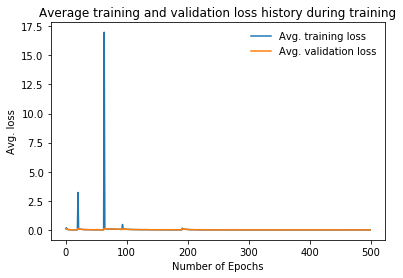

In [20]:
# Visualize the training progress by plotting training and validation loss over the number of epochs
plt.plot(train_loss_history, label='Avg. training loss')
plt.plot(valid_loss_history, label='Avg. validation loss')
plt.title('Average training and validation loss history during training')
plt.xlabel('Number of Epochs'), plt.ylabel('Avg. loss')
plt.legend(frameon=False)
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
# get a sample of test data again using the last state of the trained net model
test_images, test_outputs, test_gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(test_gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


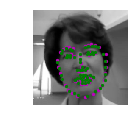

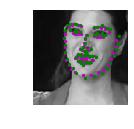

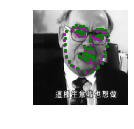

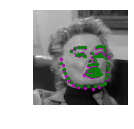

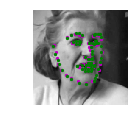

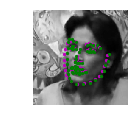

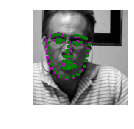

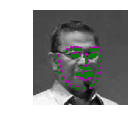

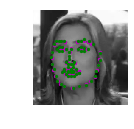

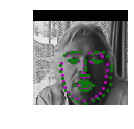

In [22]:
## TODO: visualize your test output using the last state of the trained net model
# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, test_gt_pts)

In [23]:
def test_net(test_loader, model, criterion, use_cuda):

    # evaluate test loss
    with torch.no_grad():
        
        # initialize running test loss
        running_test_loss = 0.0
        
        # set model to evaluation mode
        model.eval()
        
        # evaluate on batches of test data, assumes you already have test loader
        for batch_i, data in enumerate(test_loader):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten keypoint array
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to float tensors for regression loss and move to cuda if available
            if use_cuda:
                key_pts = key_pts.type(torch.FloatTensor).cuda()
                images = images.type(torch.FloatTensor).cuda()
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
            
            # forward pass to get predicted outputs
            output_pts = model(images)

            # calculate the test_batch_loss between predicted and target keypoints
            test_batch_loss = criterion(output_pts, key_pts)
            
            # convert current test_batch_loss into a scalar and add it to the avg. running_test_loss, use .item()
            running_test_loss = (running_test_loss * batch_i + test_batch_loss.item()) / (batch_i + 1)
    
        # Print overall average test loss
        print('Overall average test loss: {:.6f}\n'.format(running_test_loss))
    
    # Return overall average test lost
    return running_test_loss

In [24]:
# evaluate the last state of the trained net model on the test data set
test_loss = test_net(test_loader, net, criterion, use_cuda)

Overall average test loss: 0.002398



Once you've found a good model (or two), save your model so you can load it and use it later!

In [25]:
## TODO: change the name to something uniqe for each new model
#model_dir = 'saved_models/'
#model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
#torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

- Since this is a regression task (detecting facial features and finding their correct positions in the image) a loss function that is recommended for such tasks is likely a good choice. I have tested both MSELoss (mean squared error loss) and SmoothL1Loss criterion since both criteria are often used for regression tasks. SmoothL1Loss also incorporates a squared error term if the loss falls below a certain threshold, otherwise it uses L1 loss.  

- Experiments with the different net models I have tested show that SmoothL1Loss usually leads to better fits of the facial keypoints for this specific problem.  

- So SmoothL1Loss was the final choice due to the outcome.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

- I have started with a rather standard CNN structures with a feature detector block consisting of 3...5 convolutional layers (3x3 kernel size, stride = 1, padding = 1) with max pooling layers (kernel size = 2x2, stride = 2) and a classifier block with 2...3 fully connected linear layers. For the models no. 0 resp. no. 1 with 3 resp. 4 convolutional layers I have increased the stride of the convolutional filter kernel to stride = 2 for the last two resp. for the last convolutional layer in order to reduce memory demand on the GPU. All convolutional and linear layers are followed by a 2d resp. 1d batch normalization layer except for the output layer. In order to prevent overfitting and to decrease the chance to get trapped in local loss minima I have added dropout layers to each layer except for the output one with constant dropout probability of 20...30% or layer-dependent dropout probability increasing from 10% for the first convolutional layer up to 30% for the last convolutional layer and the fully connected layers. I have used relu activation functions for both convolutional and linear layers. I have also tried out elu functions with small negative part (alpha = 0.1) and leaky_relu functions with small negative slope = 0.01.  

- Overview on the tested models:

| Column 1 | Column 2 | Column 3 | Column 4 | Column 5 |
| :------: | :------: | :------: | :------: | :------: |
| model no. | 0 | 1 | 2 | 3 |
| link | [model_0](model_0.py) | [model_1](model_1.py) |  [model_2](model_2.py) | [model_3](model_3.py) | 
| convolutional layers | 3 | 4 | 5 | 5 |
| convolutional layer activation | relu | relu | relu | relu | elu |
| linear layers | 2 | 3 | 4 | 5 | 5 |
| linear layer activation | relu | relu | relu | relu | leaky relu |
| min. average training loss during training | 0.004638 (epoch 91) | 0.003101 (epoch 93) | 0.003869 (epoch 74) | 0.007898 (epoch 67) |
| min. average validation loss during training | 0.005817 (epoch 91) | 0.003398 (epoch 93) | 0.003908 (epoch 74) | 0.006551 (epoch 67) |
| avg. training loss of last state (after 100 epochs) | 0.005284 | (epoch 93) 0.003851 | 0.003875 | 0.036391 |
| avg. validation loss of last state (after 100 epochs) | 0.006588 | 0.003676 | 0.004382 | 0.037176 |
| avg. test loss of last state (after 100 epochs) | 0.006901 | 0.003295 | 0.003341 | 0.029736 |
| training time on GeForce GTX 970M GPU for 100 epochs | 18 min 1 s | 30 min 59 s | 40 min 46 s | 40 min 7 s |

- I have trained all 4 model variants 100 epochs for comparision. For model_3 I have repeated the training for 500 epochs to see if there is any noticable improvements. When increasing the number of training epochs from 100 to 500 the average loss on the test dataset dropped from 0.029736 to 0.002398. The effort for improvement is now growing overproportionally to the benefit. So I stuck with 100 training epochs. 

- The model with elu and leaky_relu activation functions and decreasing dropout probability from first to last convolutional layer seems to have the highest potential, but also requires strong training efforts and long training times.

- What concerns testing the trained detectors on the test data set the outcome is similar for the current state of training. Some facial features are not correctly detected resp. not detected in the right position as the detector misinterprets some folds in the face as eyes, for instance. In other cases predicted facial keypoints are scaled too small compared to the real face. Here we should have more training data to see further improvements on prediction quality. Most likely the deeper networks will have a the higher potential to improve when increasing the training data set.

- In many cases the training process ended up in some local minimum and saturated until I found out that the learning rate scheduler I have used caused the problem. Without the learning rate scheduler, which helped me in other problems, the training process converged much better here. So the learning rate scheduler seems to be a rather disturbing element causing the optimization process be trapped at some local minimum. So I have swiched it off.  

- With the same weight initialization method the results vary a lot. When repeating the same initialization method several times you may end up with higher or lower loss levels at the beginning and after the training. So the starting point of the optimzation is important when training only for a low number of epochs because it determines which local minima you may catch. I have tried out four different initialization methods, but for me the standard initialization method inbuilt in pytorch (without adding anything) worked best here. When increasing the number of epochs while making use of stochasitc regularization methods like dropout the effect of the initialization becomes less important. However, if you start with a low loss due to a good initialization you have less computational effort.  

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

- As I prefer working on my local machine I am limited by my GPU memory. So I have tried to increase batch size from 10 to 20, what lead to memory issues with the larger models. So I ended up on about 16 at maximum with my final model due to cuda memory limitations. With smaller models I can increase the batch size a little further.  

- I have started testing with 10...20 epochs comparing different models and often ending up with being trapped in some local minimum (due to the learning rate scheduler as it turned out).  

- When the model and optimization parameters seemed ok for me I have increased the number of epochs up to 500 for model no. 3 with elu and leaky_relu activation functions for this was harder to train. For the other models I went for 100 epochs. During training you have quite some loss fluktuations that may show sudden spikes that can really shoot up when dropout changes parameters, but there are often quite impressive improvements, too, with much lower losses as well.  

- In most cases the training leads to a quick drop in loss at the very beginning, but then the loss curve just saturates at some level fluctuating with hardly any trend to lower. However, though there is hardly any reduction in loss the convolutional filters still seem to continue to evolve because the results get better.  

- At the beginning of the training the convolutional filters behave like some kind of blurring filters. After some more training epochs they slowly turn into some kind of corner or edge detector. So therefore I conclude that facial keypoint detection often needs a longer training time.  

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.25434673 -0.2404824   0.26352954]
 [-0.48110774  0.13799168  0.45331404]
 [-0.0202468  -0.23935276  0.4897236 ]]
(3, 3)


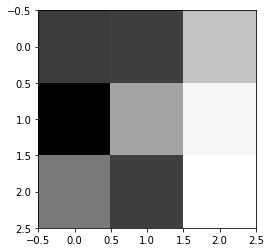

In [26]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1[0].weight.data.cpu() # net.conv1[0] => conv2d layer | net.conv1[1] => batch_norm layer

w1 = weights1.numpy()
# print(w1)
# print(w1.shape)

# First layer has 32 filter kernels of size 1 x 3 x 3
filter_index = 31 # 0...31 => second index is fixed to zero as there is only one gray/color channel

print(w1[filter_index][0])
print(w1[filter_index][0].shape)

# display the filter weights
plt.imshow(w1[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

<function matplotlib.pyplot.show(*args, **kw)>

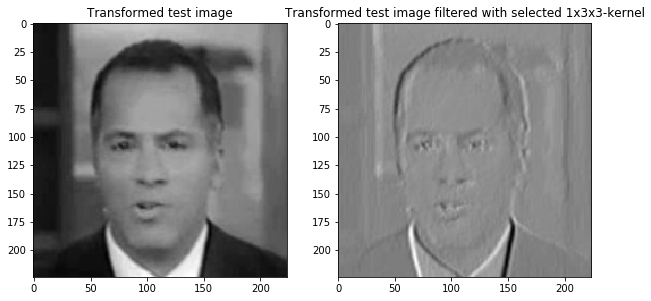

In [27]:
##TODO: load in and display any image from the transformed test dataset

# Get random sample batch from test loader
sample_batch = next(iter(test_loader)) # returns a list of dictionaries with the keys 'image' and 'keypoints'
image = sample_batch['image'][0].data # get first image from test sample batch
#print(image.size())

# un-transform the tensor format of the sample image and convert it back to numpy image format
image = image.numpy()                    # convert tensor to numpy array
image = np.transpose(image, (1, 2, 0))   # transpose image to go from torch to numpy image format
#print(image.shape)

# Plot the selected test image
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')
plt.title('Transformed test image')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
w1_filtered_image = cv2.filter2D(image, -1, w1[filter_index][0])

# plot the filtered test image
ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(w1_filtered_image), cmap='gray')
plt.title('Transformed test image filtered with selected 1x3x3-kernel')
plt.show

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

- The trained filter properties seem to depend heavily on the number of training cycles resp. epochs.  

- When the training process is run just for a few epochs the filter coefficients still resemble their random initialization state so that the filter effect is weak. It mainly leads to blurring effects when such a kernel is applied directly on the input image. 

- When the training process has evolved over a larger number of epochs the filters are turned into some kind of edge or corner detectors still combined with blurring effects. But this is not always the case.  

- The filters of the deeper layers are more like edge detectors. However, to shape their properties takes quite a while of training.  

In [28]:
# Make predictions on a sample batch of images returing activations, feature maps and layer outputs of the CNN model
def net_sample_outputs_per_layer():
    
    # Switch off gradients in net model for efficient evaluation
    with torch.no_grad():
        
        # Set model to evaluation mode (switch off dropout)
        net.eval()
        
        # Get random sample batch from test loader
        sample_batch = next(iter(test_loader)) # returns a list of dictionaries with the keys 'image' and 'keypoints'
        
        # get sample data of the first image of the batch: images and ground truth keypoints
        images = sample_batch['image']
        gt_key_pts = sample_batch['keypoints']
        
        # convert images to FloatTensors and move to cuda if available
        if use_cuda:
            images = images.type(torch.FloatTensor).cuda()
        else:
            images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        output_pts, activations, feature_maps, layer_outputs = net.predict(images)
        # output_pts, feature_maps = net.predict(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # Copy tensor of images, output_pts, activations, feature_maps and layer_outputs back to CPU if they are not there yet
        images = images.cpu()
        output_pts = output_pts.detach().cpu() # detach the tensors from the model graph
        for layer in activations.keys():
            activations[layer] = activations[layer].detach().cpu()
        for layer in feature_maps.keys():
            feature_maps[layer] = feature_maps[layer].detach().cpu()
        for layer in layer_outputs.keys():
            layer_outputs[layer] = layer_outputs[layer].detach().cpu()
        
        # Retunr batch of images, ground truth key points, predicted keypoints, activations, feaature maps and layer outputs
        return images, output_pts, activations, feature_maps, layer_outputs, gt_key_pts
        # return images, output_pts, feature_maps, gt_key_pts

In [29]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, \
test_output_pts, \
test_activations, \
test_feature_maps, \
test_layer_outputs, \
test_gt_pts = net_sample_outputs_per_layer()
# test_images, test_output_pts, test_feature_maps, test_gt_pts = net_sample_outputs_per_layer()

# print out the dimensions of the data to see if they make sense
print('Shape of input image batch tensor: \n{}'.format(test_images.data.size()))
print('Shape of predicted keypoints batch tensor: \n{}'.format(test_output_pts.data.size()))
print('Shape of ground truth keypoints batch tensor: \n{}'.format(test_gt_pts.size()))

Shape of input image batch tensor: 
torch.Size([16, 1, 224, 224])
Shape of predicted keypoints batch tensor: 
torch.Size([16, 68, 2])
Shape of ground truth keypoints batch tensor: 
torch.Size([16, 68, 2])


In [30]:
# print dictionary of activations
for layer in test_activations.keys():
    print('Shape of activation tensor in layer "{}": {}'.format(layer, test_activations[layer].shape))
#print('Activations dictionary with batch of tensors: \n{}'.format(test_activations))

Shape of activation tensor in layer "conv1": torch.Size([16, 32, 224, 224])
Shape of activation tensor in layer "conv2": torch.Size([16, 64, 112, 112])
Shape of activation tensor in layer "conv3": torch.Size([16, 128, 56, 56])
Shape of activation tensor in layer "conv4": torch.Size([16, 256, 28, 28])
Shape of activation tensor in layer "conv5": torch.Size([16, 512, 14, 14])
Shape of activation tensor in layer "fc1": torch.Size([16, 1024])
Shape of activation tensor in layer "fc2": torch.Size([16, 1024])


In [31]:
# print dictionary of feature maps
for layer in test_feature_maps.keys():
    print('Shape of feature maps tensor in layer "{}": {}'.format(layer, test_feature_maps[layer].shape))
# print('Feature maps dictionary with batch of tensors: \n{}'.format(test_feature_maps))

Shape of feature maps tensor in layer "conv1": torch.Size([16, 32, 224, 224])
Shape of feature maps tensor in layer "conv2": torch.Size([16, 64, 112, 112])
Shape of feature maps tensor in layer "conv3": torch.Size([16, 128, 56, 56])
Shape of feature maps tensor in layer "conv4": torch.Size([16, 256, 28, 28])
Shape of feature maps tensor in layer "conv5": torch.Size([16, 512, 14, 14])


In [32]:
# print dictionary of layer outputs
for layer in test_layer_outputs.keys():
    print('Shape of layer outputs tensor in layer "{}": {}'.format(layer, test_layer_outputs[layer].shape))
# print('Layer outputs dictionary with batch of tensors: \n{}'.format(test_layer_outputs))

Shape of layer outputs tensor in layer "pool_conv1": torch.Size([16, 32, 112, 112])
Shape of layer outputs tensor in layer "pool_conv2": torch.Size([16, 64, 56, 56])
Shape of layer outputs tensor in layer "pool_conv3": torch.Size([16, 128, 28, 28])
Shape of layer outputs tensor in layer "pool_conv4": torch.Size([16, 256, 14, 14])
Shape of layer outputs tensor in layer "pool_conv5": torch.Size([16, 512, 7, 7])
Shape of layer outputs tensor in layer "fc1": torch.Size([16, 1024])
Shape of layer outputs tensor in layer "fc2": torch.Size([16, 1024])


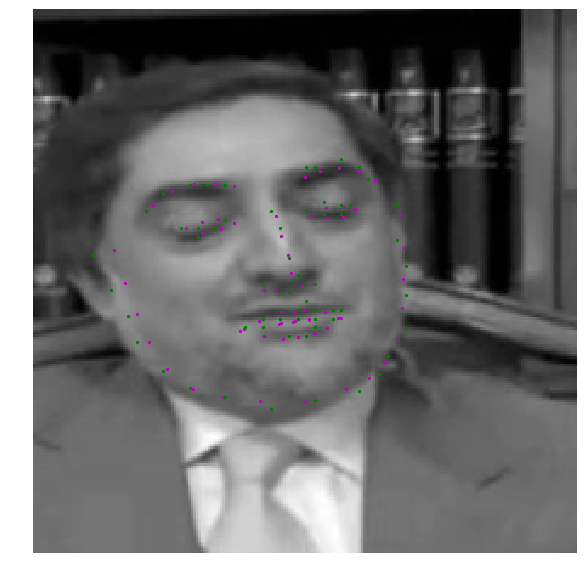

In [33]:
# visualize one batch of test images
visualize_output(test_images, test_output_pts, test_gt_pts, batch_size=1)

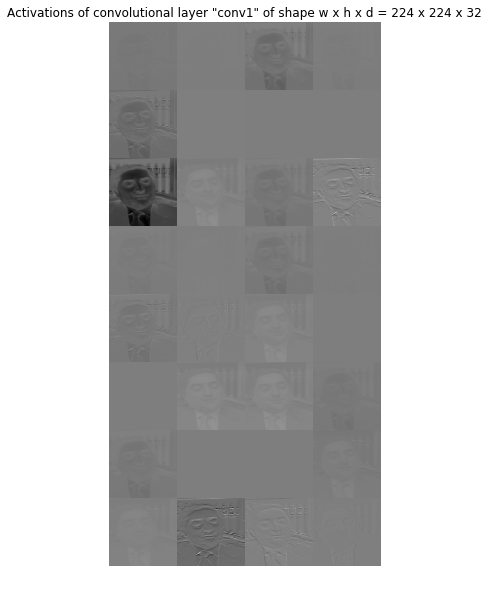

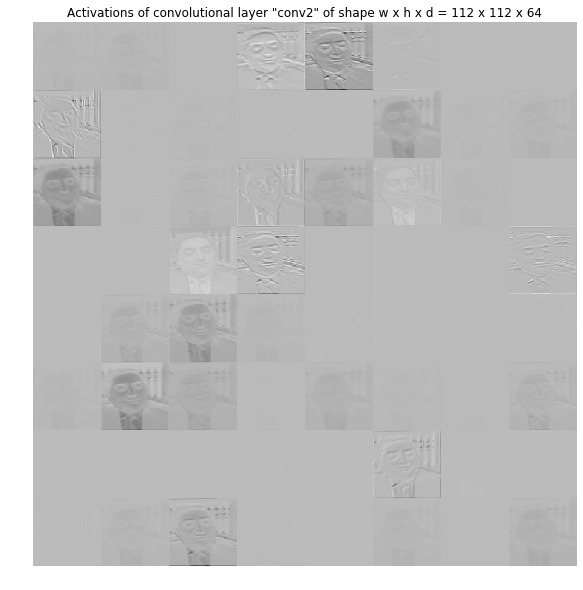

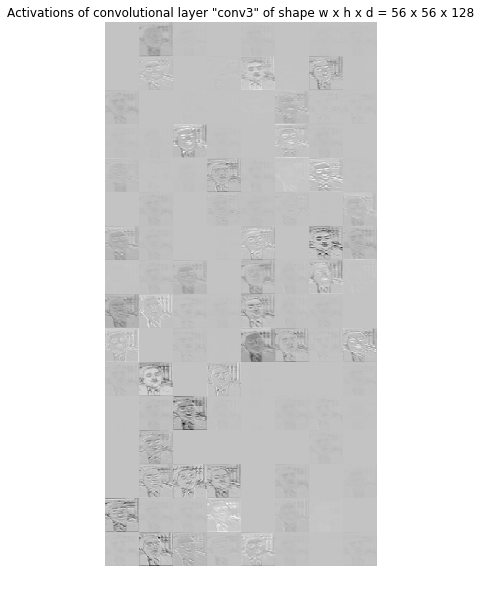

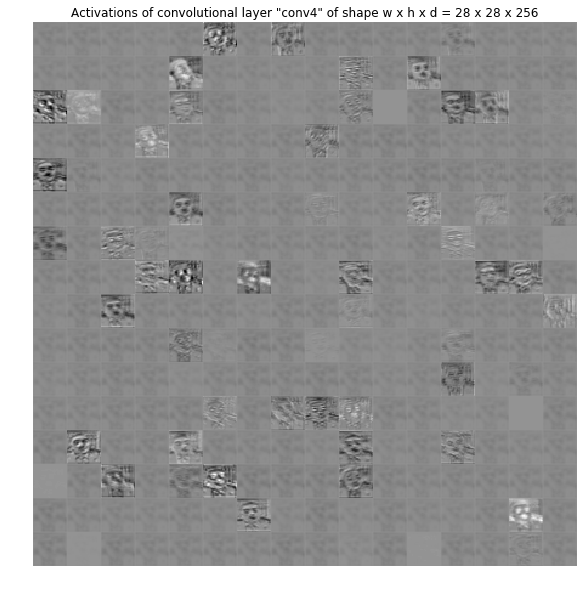

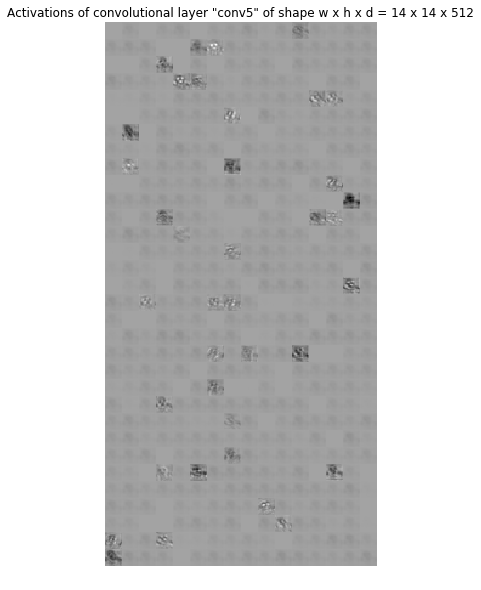

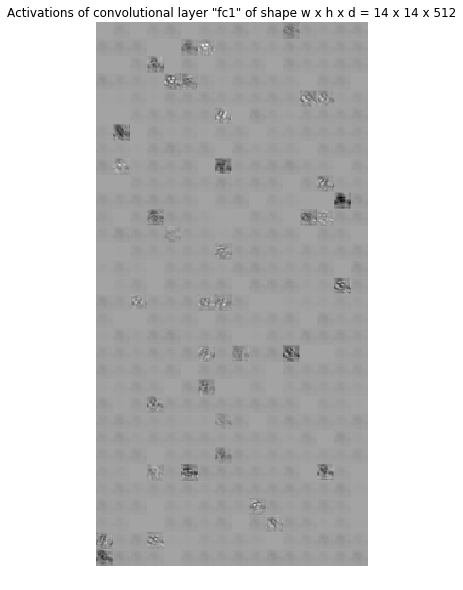

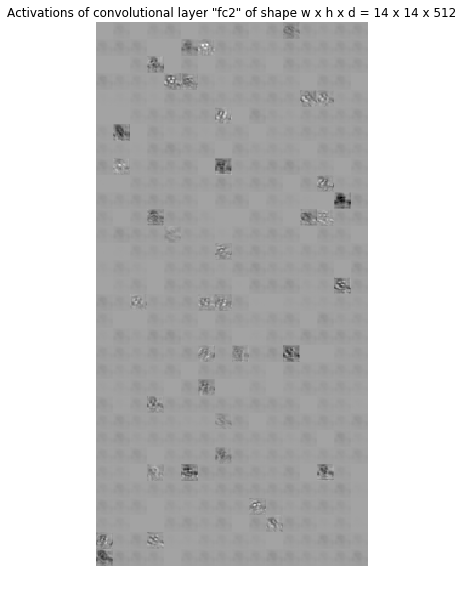

In [34]:
# visualize the activations of all convolutional hidden layers
# by default this shows a single-image-batch
def visualize_activations(activations, batch_size=1):

    # Loop over the batch
    for i in range(batch_size):
        
        # Loop over the activations of all hidden layers
        for layer in activations.keys():
            
            # Consider only convolutional layers
            if 'conv' in layer:
                
                # get the shape of the activations of the current convolutional layer
                #d, w, h = activations[layer][i].data.shape
                
                # un-transform the activations for each convolutional layer from tensor to numpy
                # print(activations[layer][i].data.shape)
                amaps = activations[layer][i].data # get the activations of ith layer
                amaps = amaps.numpy() # convert activations from tensor to numpy 
                amaps = np.transpose(amaps, (1, 2, 0)) # transpose to go from torch tensor to numpy image format
                activations[layer] = amaps # write un-transformed activations back to dictionary
                # print(amaps.shape)
                
                # get the shape of the activations of the current convolutional layer
                w, h, d = amaps.shape
            
            # Get optimal arrangement of the activation images for each convolutional layer in the plot
            cols = int(np.power(2, np.floor(np.log2(np.sqrt(d)))))
            rows = int(d / cols)
            # print(cols)
            # print(rows)
            
            # Initialize activations image
            amaps_image = np.zeros((h * rows, w * cols))
            # print(amaps_image.shape)
            
            # Loop over all activations of the current convolutional layer
            for row_idx in range(rows):
                for col_idx in range(cols):
                    idx = row_idx * cols + col_idx
                    amaps_image[row_idx*h:(row_idx+1)*h,col_idx*w:(col_idx+1)*w] = amaps[:, :, idx]
            
            # Show all the activations of the current convolutional layer in a new single plot
            plt.figure(figsize=(20,10))
            plt.imshow(amaps_image, cmap='gray')
            plt.axis('off')
            plt.title('Activations of convolutional layer "{}" of shape w x h x d = {} x {} x {}'.format(layer,
                                                                                                         w, h, d))
    # Show all plots
    plt.show()

# Visualize the activations of all hidden layers of the net model resulting from the test image input
visualize_activations(test_activations)

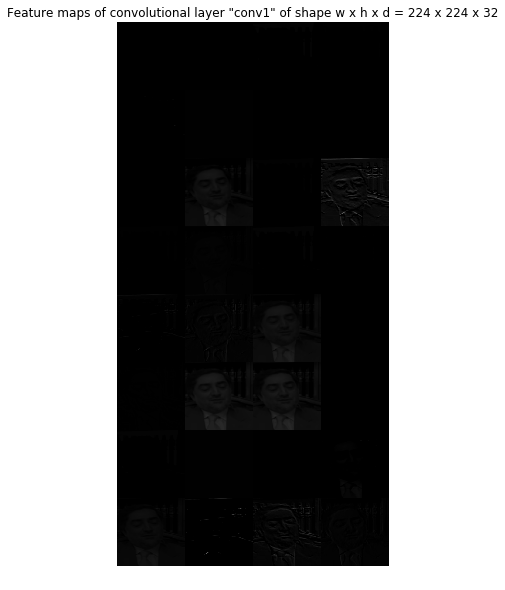

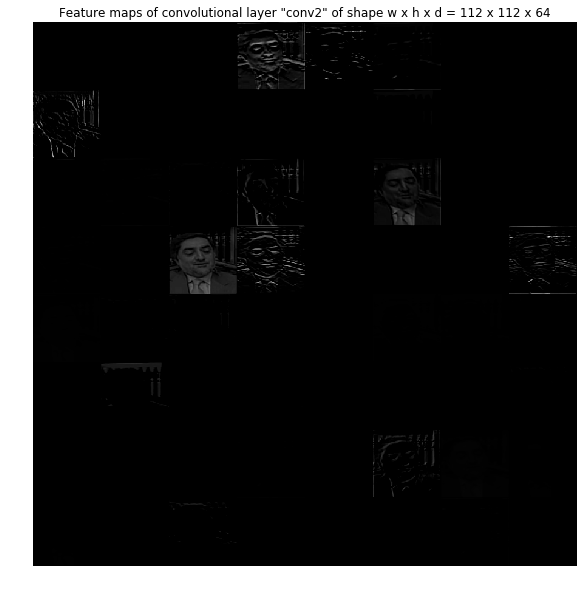

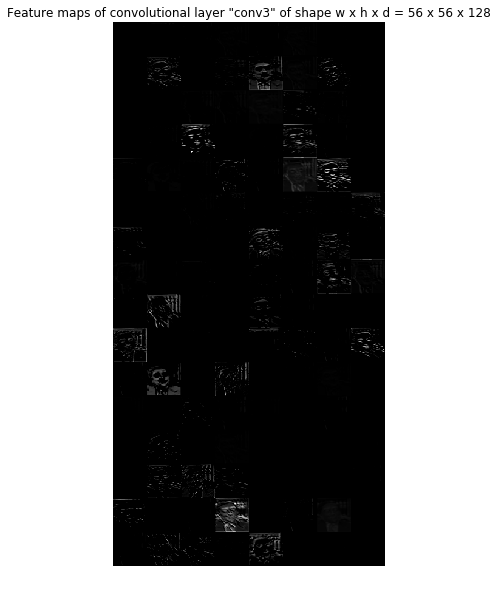

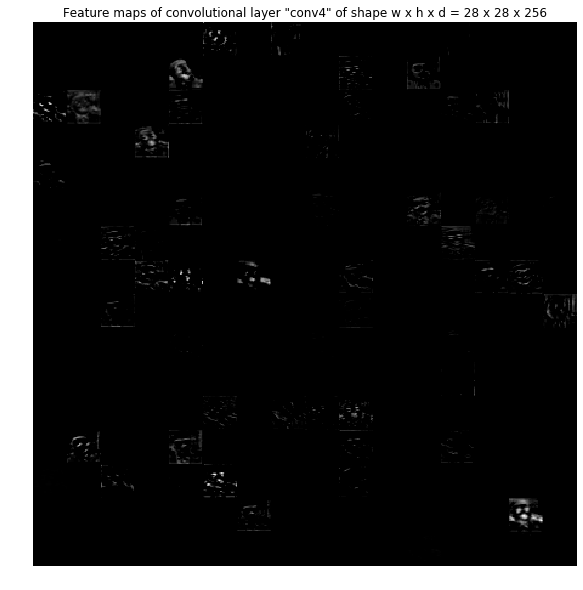

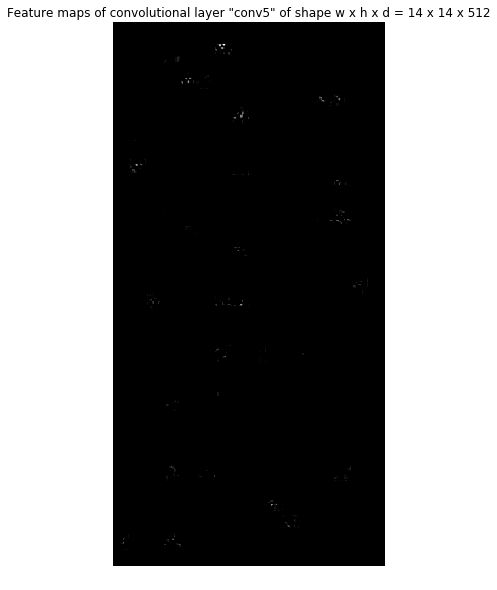

In [35]:
# visualize the feature maps of all convolutional layers
# by default this shows a single-image-batch
def visualize_feature_maps(feature_maps, batch_size=1):

    # Loop over the batch
    for i in range(batch_size):
        
        # Loop over the feature maps of all convolutional layers
        for layer in feature_maps.keys():
                        
            # Consider only convolutional layers
            if 'conv' in layer:
                
                # get the shape of the feature maps of the current convolutional layer
                #d, w, h = feature_maps[layer][i].data.shape
                
                # un-transform the feature maps for each layer from tensor to numpy
                # print(feature_maps[layer][i].data.shape)
                fmaps = feature_maps[layer][i].data # get the feature maps of ith layer
                fmaps = fmaps.numpy() # convert feature maps from tensor to numpy 
                fmaps = np.transpose(fmaps, (1, 2, 0)) # transpose to go from torch tensor to numpy image format
                feature_maps[layer] = fmaps # write un-transformed feature maps back to dictionary
                # print(fmaps.shape)
                
                # get the shape of the feature maps of the current convolutional layer
                w, h, d = fmaps.shape
            
            # Get optimal arrangement of the feature maps for each convolutional layer in the plot
            cols = int(np.power(2, np.floor(np.log2(np.sqrt(d)))))
            rows = int(d / cols)
            # print(cols)
            # print(rows)
            
            # Initialize feature maps image
            fmaps_image = np.zeros((h * rows, w * cols))
            #print(fmaps_image.shape)
            
            # Loop over all feature maps of the current convolutional layer
            for row_idx in range(rows):
                for col_idx in range(cols):
                    idx = row_idx * cols + col_idx
                    fmaps_image[row_idx*h:(row_idx+1)*h,col_idx*w:(col_idx+1)*w] = fmaps[:, :, idx]
            
            # Show all the feature maps of the current convolutional layer in a new single plot
            plt.figure(figsize=(20,10))
            plt.imshow(fmaps_image, cmap='gray')
            plt.axis('off')
            plt.title('Feature maps of convolutional layer "{}" of shape w x h x d = {} x {} x {}'.format(layer,
                                                                                                         w, h, d))
    # Show all plots  
    plt.show()

# Visualize the feature maps of all convolutional layers of the net model resulting from the test image input
visualize_feature_maps(test_feature_maps)

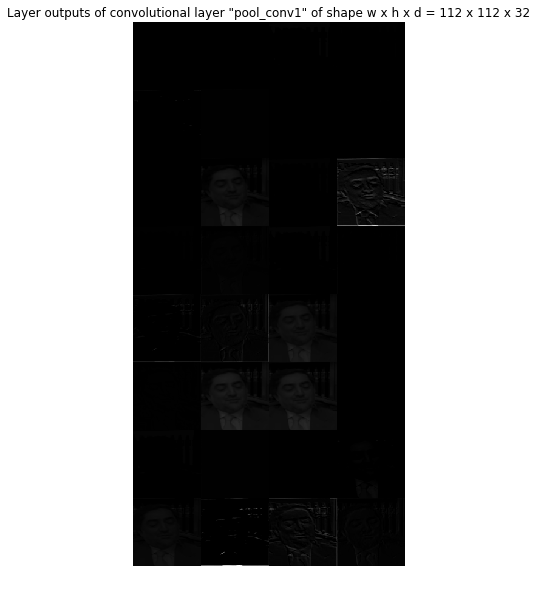

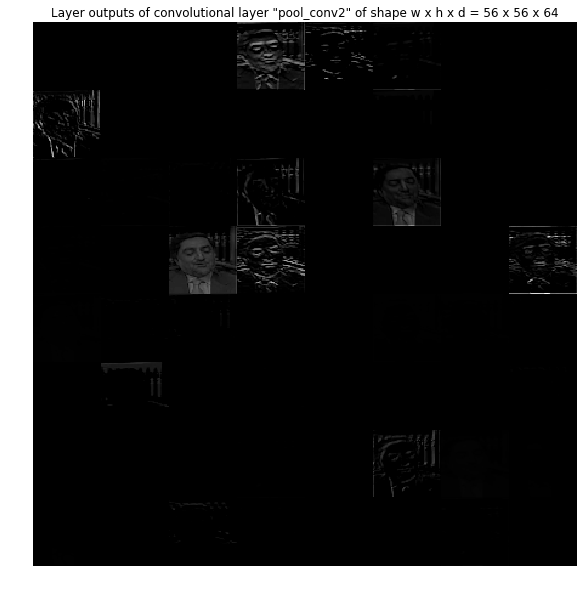

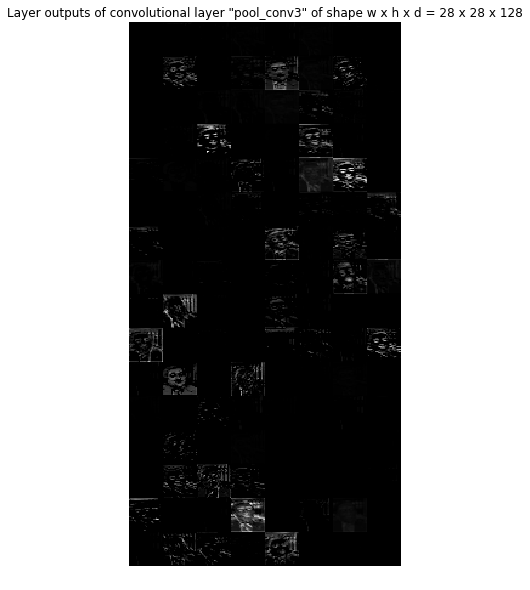

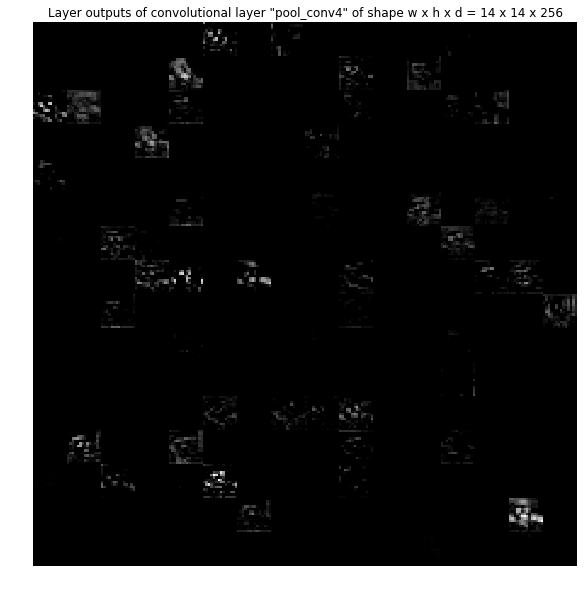

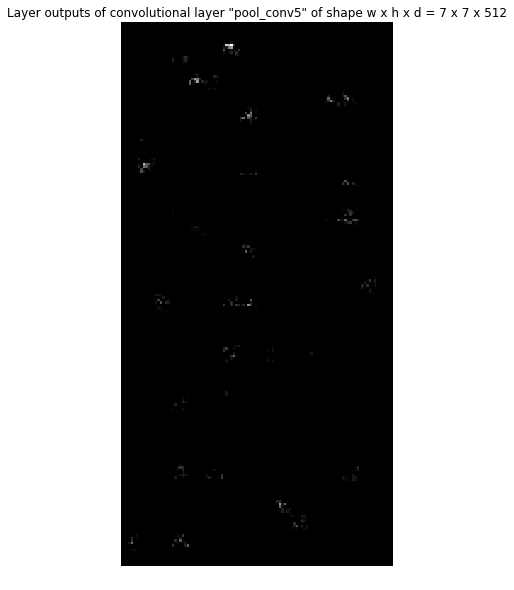

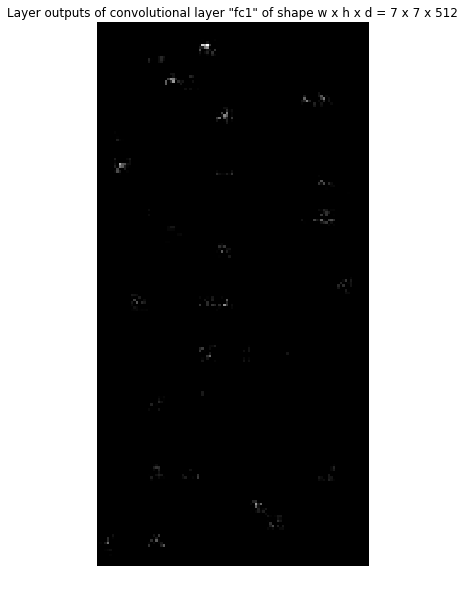

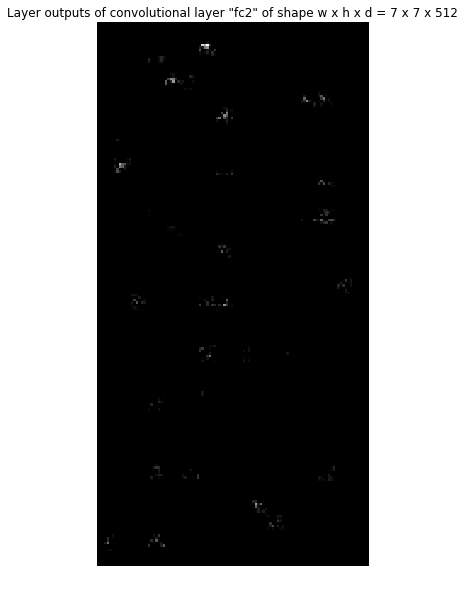

In [36]:
# visualize the layer outputs of all convolutional hidden layers
# by default this shows a single-image-batch
def visualize_layer_outputs(layer_outputs, batch_size=1):

    # Loop over the batch
    for i in range(batch_size):
        
        # Loop over the layer outputs of all convolutional layers
        for layer in layer_outputs.keys():
            
            # Consider only convolutional layers
            if 'conv' in layer:
                
                # get the shape of the layer outputs of the current convolutional layer
                d, w, h = layer_outputs[layer][i].data.shape
                
                # un-transform the layer outputs for each convolutional layer from tensor to numpy
                # print(layer_outputs[layer][i].data.shape)
                lomaps = layer_outputs[layer][i].data # get the layer outputs of ith layer
                lomaps = lomaps.numpy() # convert layer outputs from tensor to numpy 
                lomaps = np.transpose(lomaps, (1, 2, 0)) # transpose to go from torch tensor to numpy image format
                layer_outputs[layer] = lomaps # write un-transformed layer outputs back to dictionary
                # print(lomaps.shape)
                
                # get the shape of the layer outputs of the current convolutional layer
                w, h, d = lomaps.shape
            
            # Get optimal arrangement of the layer output images for each convolutional layer in the plot
            cols = int(np.power(2, np.floor(np.log2(np.sqrt(d)))))
            rows = int(d / cols)
            # print(cols)
            # print(rows)
            
            # Initialize layer outputs image
            lomaps_image = np.zeros((h * rows, w * cols))
            # print(lomaps_image.shape)
            
            # Loop over all layer outputs of the current convolutional layer
            for row_idx in range(rows):
                for col_idx in range(cols):
                    idx = row_idx * cols + col_idx
                    lomaps_image[row_idx*h:(row_idx+1)*h,col_idx*w:(col_idx+1)*w] = lomaps[:, :, idx]
            
            # Show all the feature maps of the current layer in a new single plot
            plt.figure(figsize=(20,10))
            plt.imshow(lomaps_image, cmap='gray')
            plt.axis('off')
            plt.title('Layer outputs of convolutional layer "{}" of shape w x h x d = {} x {} x {}'.format(layer,
                                                                                                         w, h, d))
    # Show all plots  
    plt.show()

# Visualize the layer outputs of all convolutional layers of the net model resulting from the test image input
visualize_layer_outputs(test_layer_outputs)

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!